In [2]:
#Linear regression
from sklearn.linear_model import LinearRegression

#Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

import csv
import pandas as pd
from collections import defaultdict
import numpy as np

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
plt.rcParams['figure.dpi'] = 360

In [3]:
rosettes = [3,6,7,11,12,13,14,15,18,19]

### Create graph

In [4]:

def graph_r(r):

    nodes = []
    edges = []
    edges_distances = []

    with open(f'./data/rosette{r}_nodes.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                values = list(row.values())
                n = []
                n.append(float(values[0]))
                n.append(float(values[1]))
                n.extend(22.5-2.5*np.log10([float(n) for n in values[2:-1]]))
                n.append(np.log10(float(values[-1])))
                nodes.append(n)

    with open(f'./data/rosette{r}_edges.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                edges_distances.append([float(n) for n in list(row.values())])
                edges.append([float(n) for n in list(row.values())][:2])

    return (nodes,edges,edges_distances)

In [5]:
nodes, edges, distances = graph_r(rosettes[0])

### Correlation matrix

/var/folders/ls/yc9nb2gx14s6sstnjr_fcy5r0000gn/T/ipykernel_53652/1155875418.py:8: RuntimeWarning: divide by zero encountered in log10
  ed = [np.log10(c[n[0]]) for n in nodes]


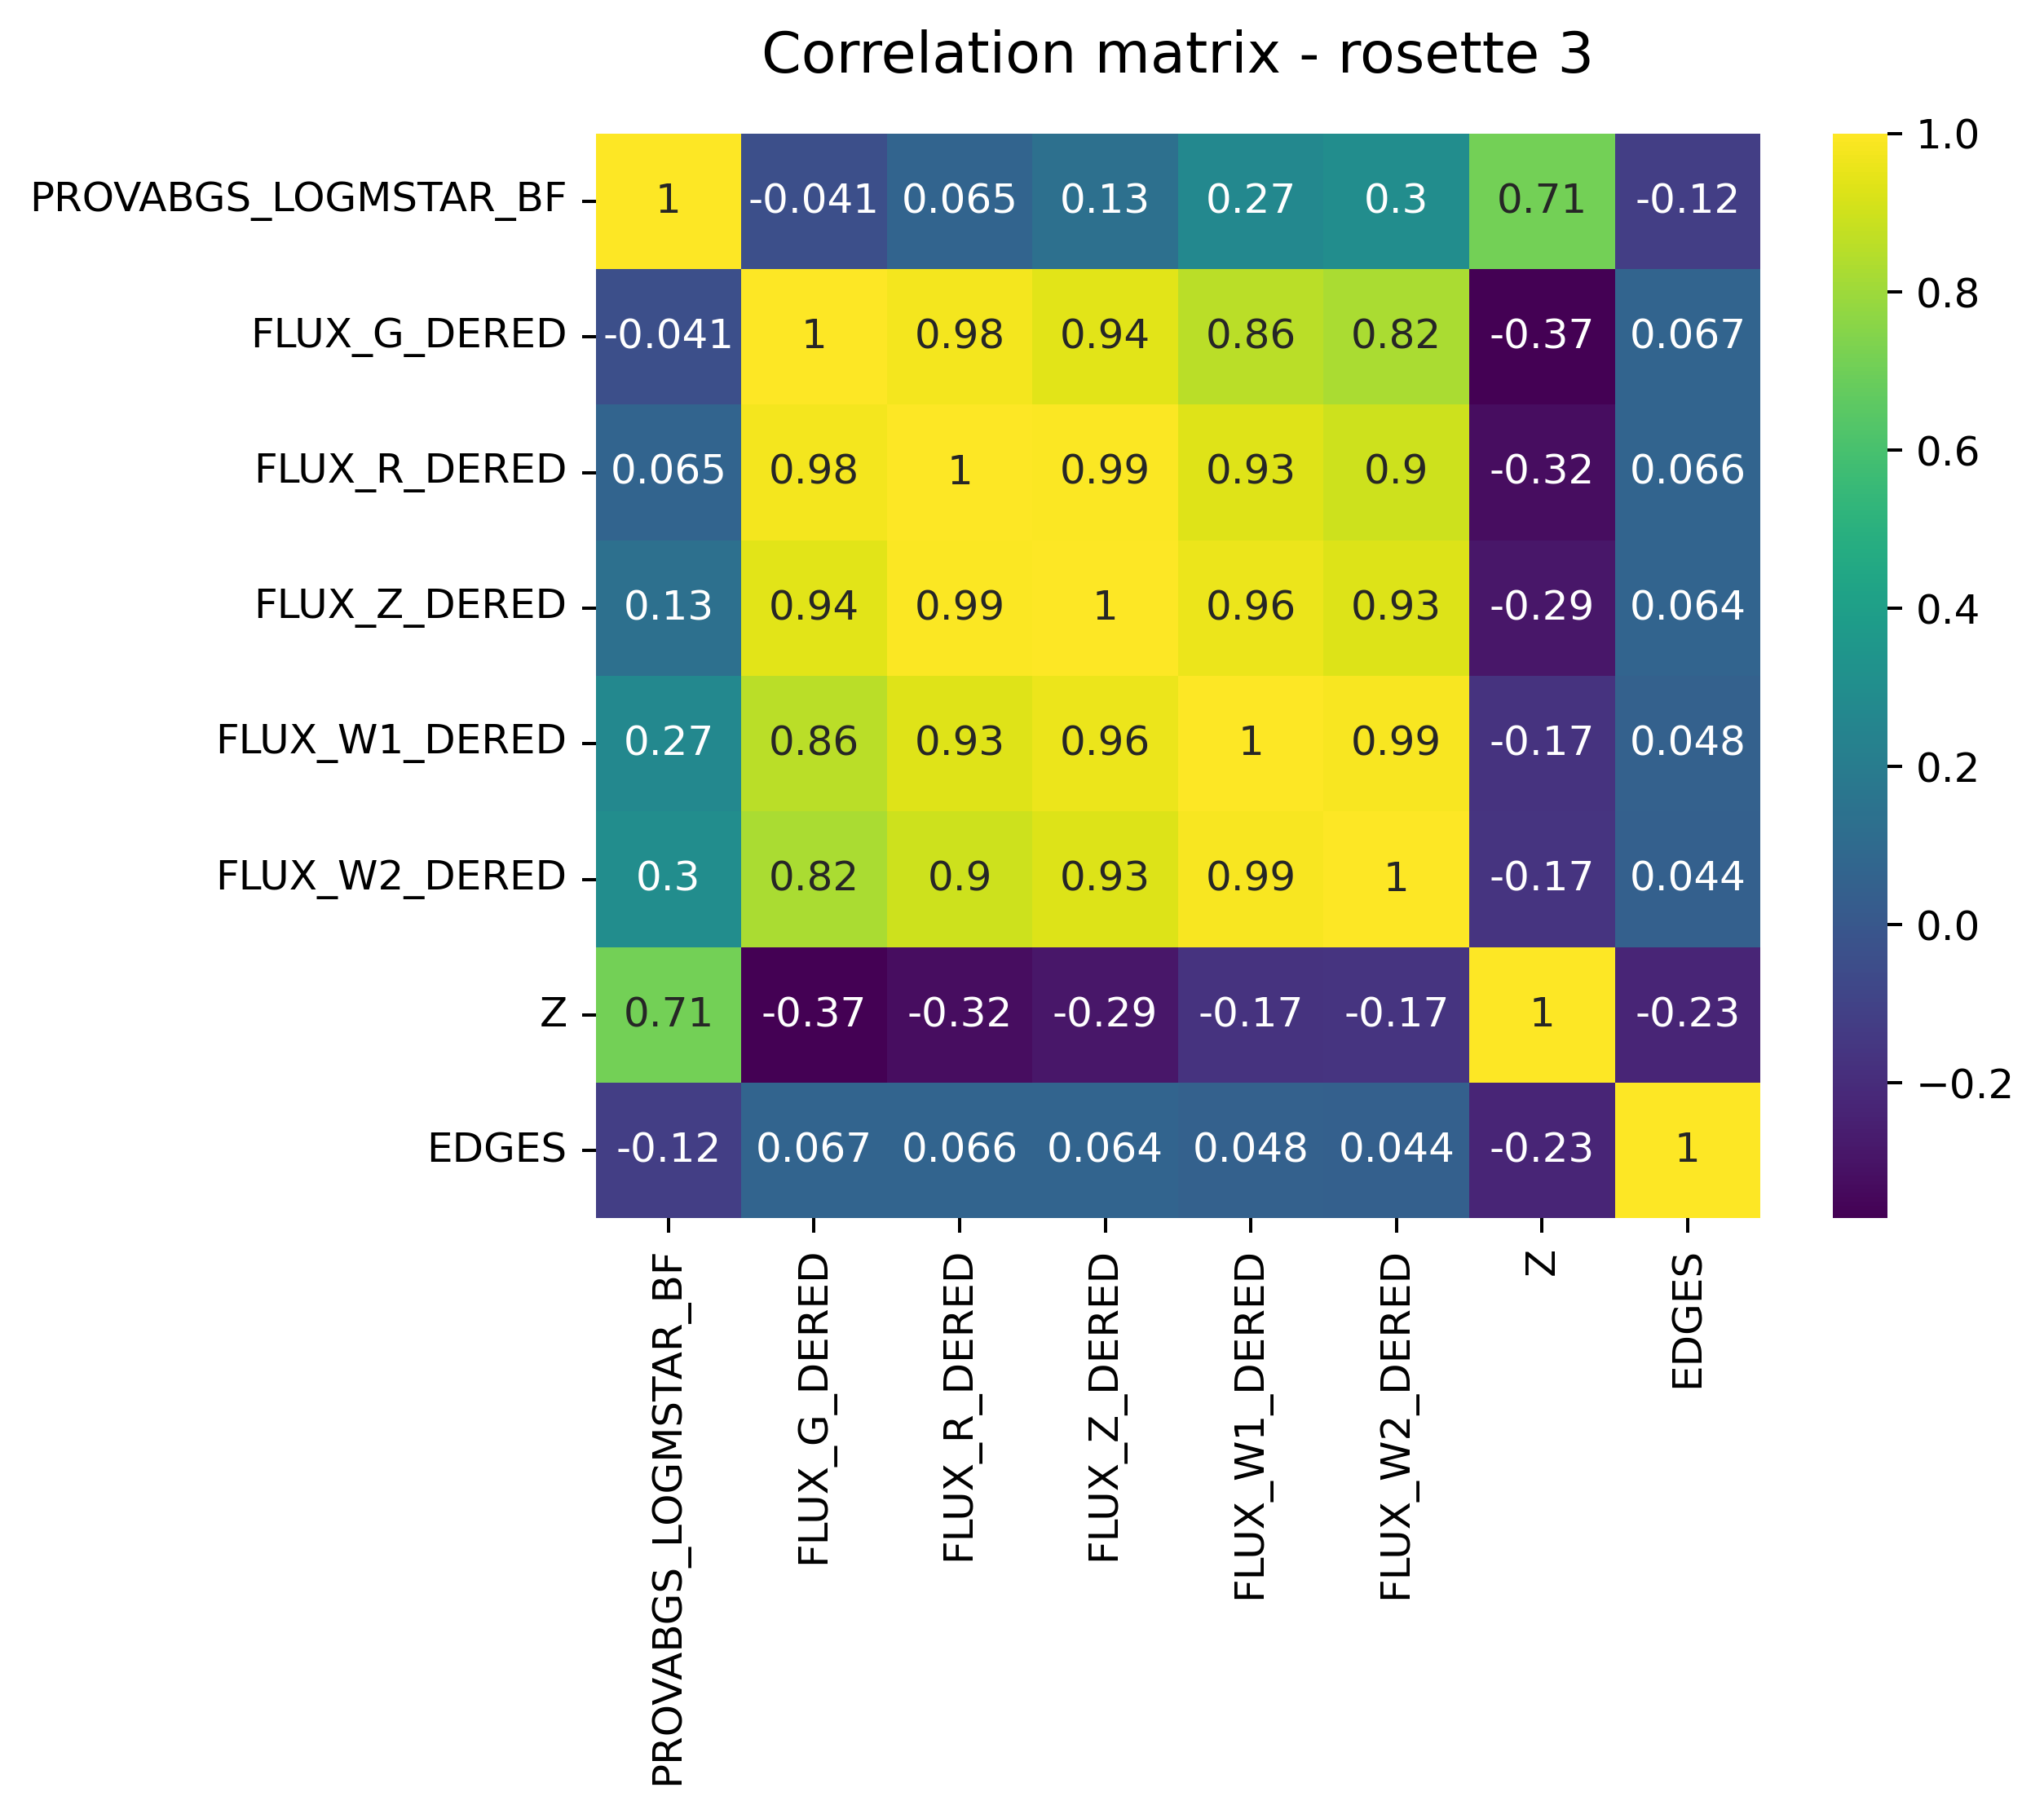

In [6]:
def correlation_matrix(r,nodes,edges):

    df = pd.read_csv(f'./data/rosette{r}_nodes.csv')
    c = defaultdict(int)
    for edge in edges:
        c[edge[0]] += 1
        c[edge[1]] += 1
    ed = [np.log10(c[n[0]]) for n in nodes]
    df['EDGES'] = ed

    df.drop('TARGET_ID', axis=1, inplace=True)
    matrix = sb.heatmap(df.corr(), cmap="viridis", annot=True)
    matrix.set_title(f'Correlation matrix - rosette {r}', fontsize=14, pad=15)
    plt.show()

correlation_matrix(3,nodes,edges)

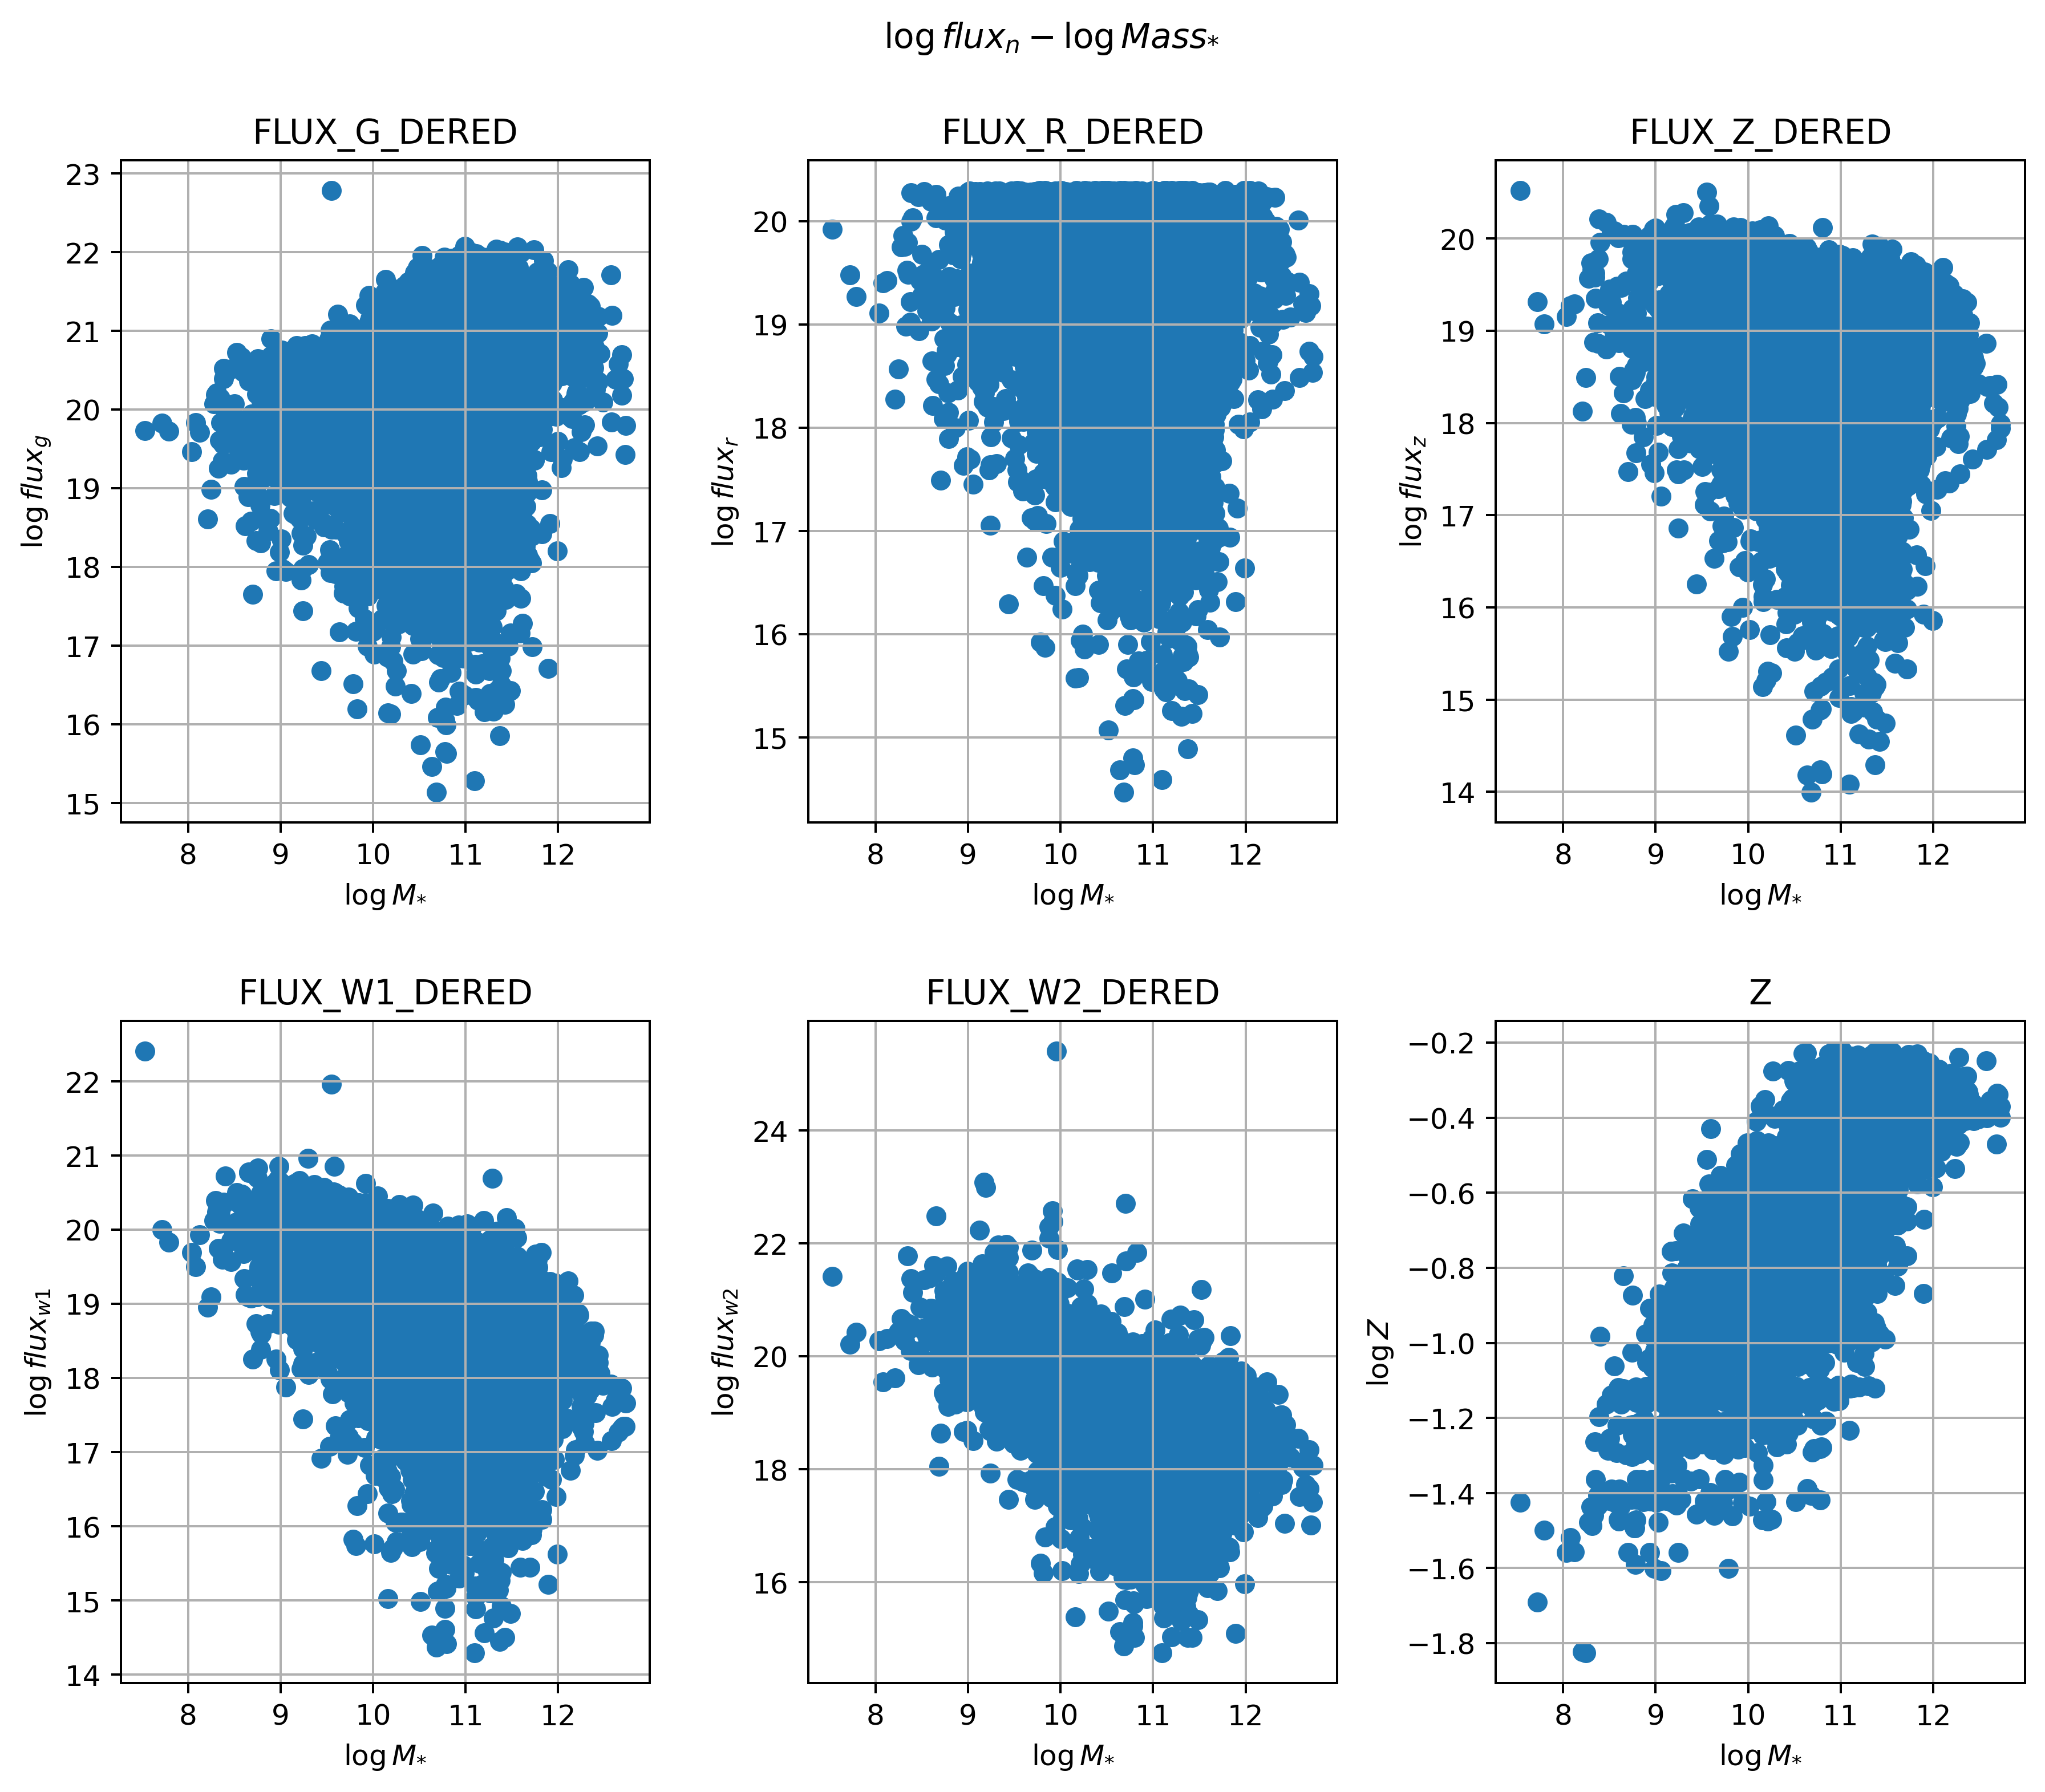

In [7]:
nodes, edges, _ = graph_r(3)

c = defaultdict(int)
for edge in edges:
    c[edge[0]] += 1
    c[edge[1]] += 1
m = [n[1] for n in nodes]
ed = [c[n[0]] for n in nodes]

f_g = [n[2] for n in nodes]
f_r = [n[3] for n in nodes]
f_z = [n[4] for n in nodes]
f_w1 = [n[5] for n in nodes]
f_w2 = [n[6] for n in nodes]
z = [n[7] for n in nodes]

cmap = cm.viridis
n = (m - np.min(m)) / (np.max(m) - np.min(m))
min_norm = np.min(m)
max_norm = np.max(m)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_norm, vmax=max_norm))
sm.set_array([])

nrows, ncols =  3, 2
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
plt.tight_layout()
plt.suptitle(r'$\log{flux_{n}}-\log{Mass_{*}}$', y=1.06)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

axes[0, 0].scatter(m, f_g, marker='o')
axes[0, 0].set_title('FLUX_G_DERED')
axes[0, 0].set_xlabel(r'$\log M_{*}$')
axes[0, 0].set_ylabel(r'$\log flux_{g}$')
axes[0, 0].grid()

axes[0, 1].scatter(m, f_r, marker='o')
axes[0, 1].set_title('FLUX_R_DERED')
axes[0, 1].set_xlabel(r'$\log M_{*}$')
axes[0, 1].set_ylabel(r'$\log flux_{r}$')
axes[0, 1].grid()

axes[0, 2].scatter(m, f_z, marker='o')
axes[0, 2].set_title('FLUX_Z_DERED')
axes[0, 2].set_xlabel(r'$\log M_{*}$')
axes[0, 2].set_ylabel(r'$\log flux_{z}$')
axes[0, 2].grid()

axes[1, 0].scatter(m, f_w1, marker='o')
axes[1, 0].set_title('FLUX_W1_DERED')
axes[1, 0].set_xlabel(r'$\log M_{*}$')
axes[1, 0].set_ylabel(r'$\log flux_{w1}$')
axes[1, 0].grid()

axes[1, 1].scatter(m, f_w2, marker='o')
axes[1, 1].set_title('FLUX_W2_DERED')
axes[1, 1].set_xlabel(r'$\log M_{*}$')
axes[1, 1].set_ylabel(r'$\log flux_{w2}$')
axes[1, 1].grid()

axes[1, 2].scatter(m, z, marker='o')
axes[1, 2].set_title('Z')
axes[1, 2].set_xlabel(r'$\log M_{*}$')
axes[1, 2].set_ylabel(r'$\log Z$')
axes[1, 2].grid()

plt.rcParams['figure.dpi'] = 360
plt.show()

## Models

### Linear Model

#### Including **one** [flux_g, flux_r, flux_z, flux_w1, flux_w2, z]

In [8]:
props = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']
x_pred, y_pred, mses = [], [], []

for p in range(len(props)):
    X, y = [], []
    model = LinearRegression()

    for r in rosettes[:1]: #* Rosette 3
        nodes, _, _ = graph_r(r)
        y.extend(np.array([n[p+2] for n in nodes])) #input flux-z
        X.extend(np.array([n[1] for n in nodes]).reshape(-1, 1)) #mass

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8)
    model.fit(X_train, y_train)

    x_pred.append([t[0] for t in X_test])
    y_pred.append((y_test,model.predict(X_test)))
    mses.append((model.score(X_test, y_test),mean_squared_error(y_test, model.predict(X_test))))
    print(f'R^2, {props[p]}: {mses[-1][0]}, mse: {mses[-1][1]}')

R^2, flux_g: 0.03197841484544017, mse: 0.8736569460628407
R^2, flux_r: 0.010560535138899763, mse: 0.7028111365224903
R^2, flux_z: 0.07572973032046904, mse: 0.6828511444139551
R^2, flux_w1: 0.32547614509096323, mse: 0.5442768601476012
R^2, flux_w2: 0.35635193185034597, mse: 0.542535632976566
R^2, z: 0.5339362628171171, mse: 0.022356009397966354


Predictions in the same rosette

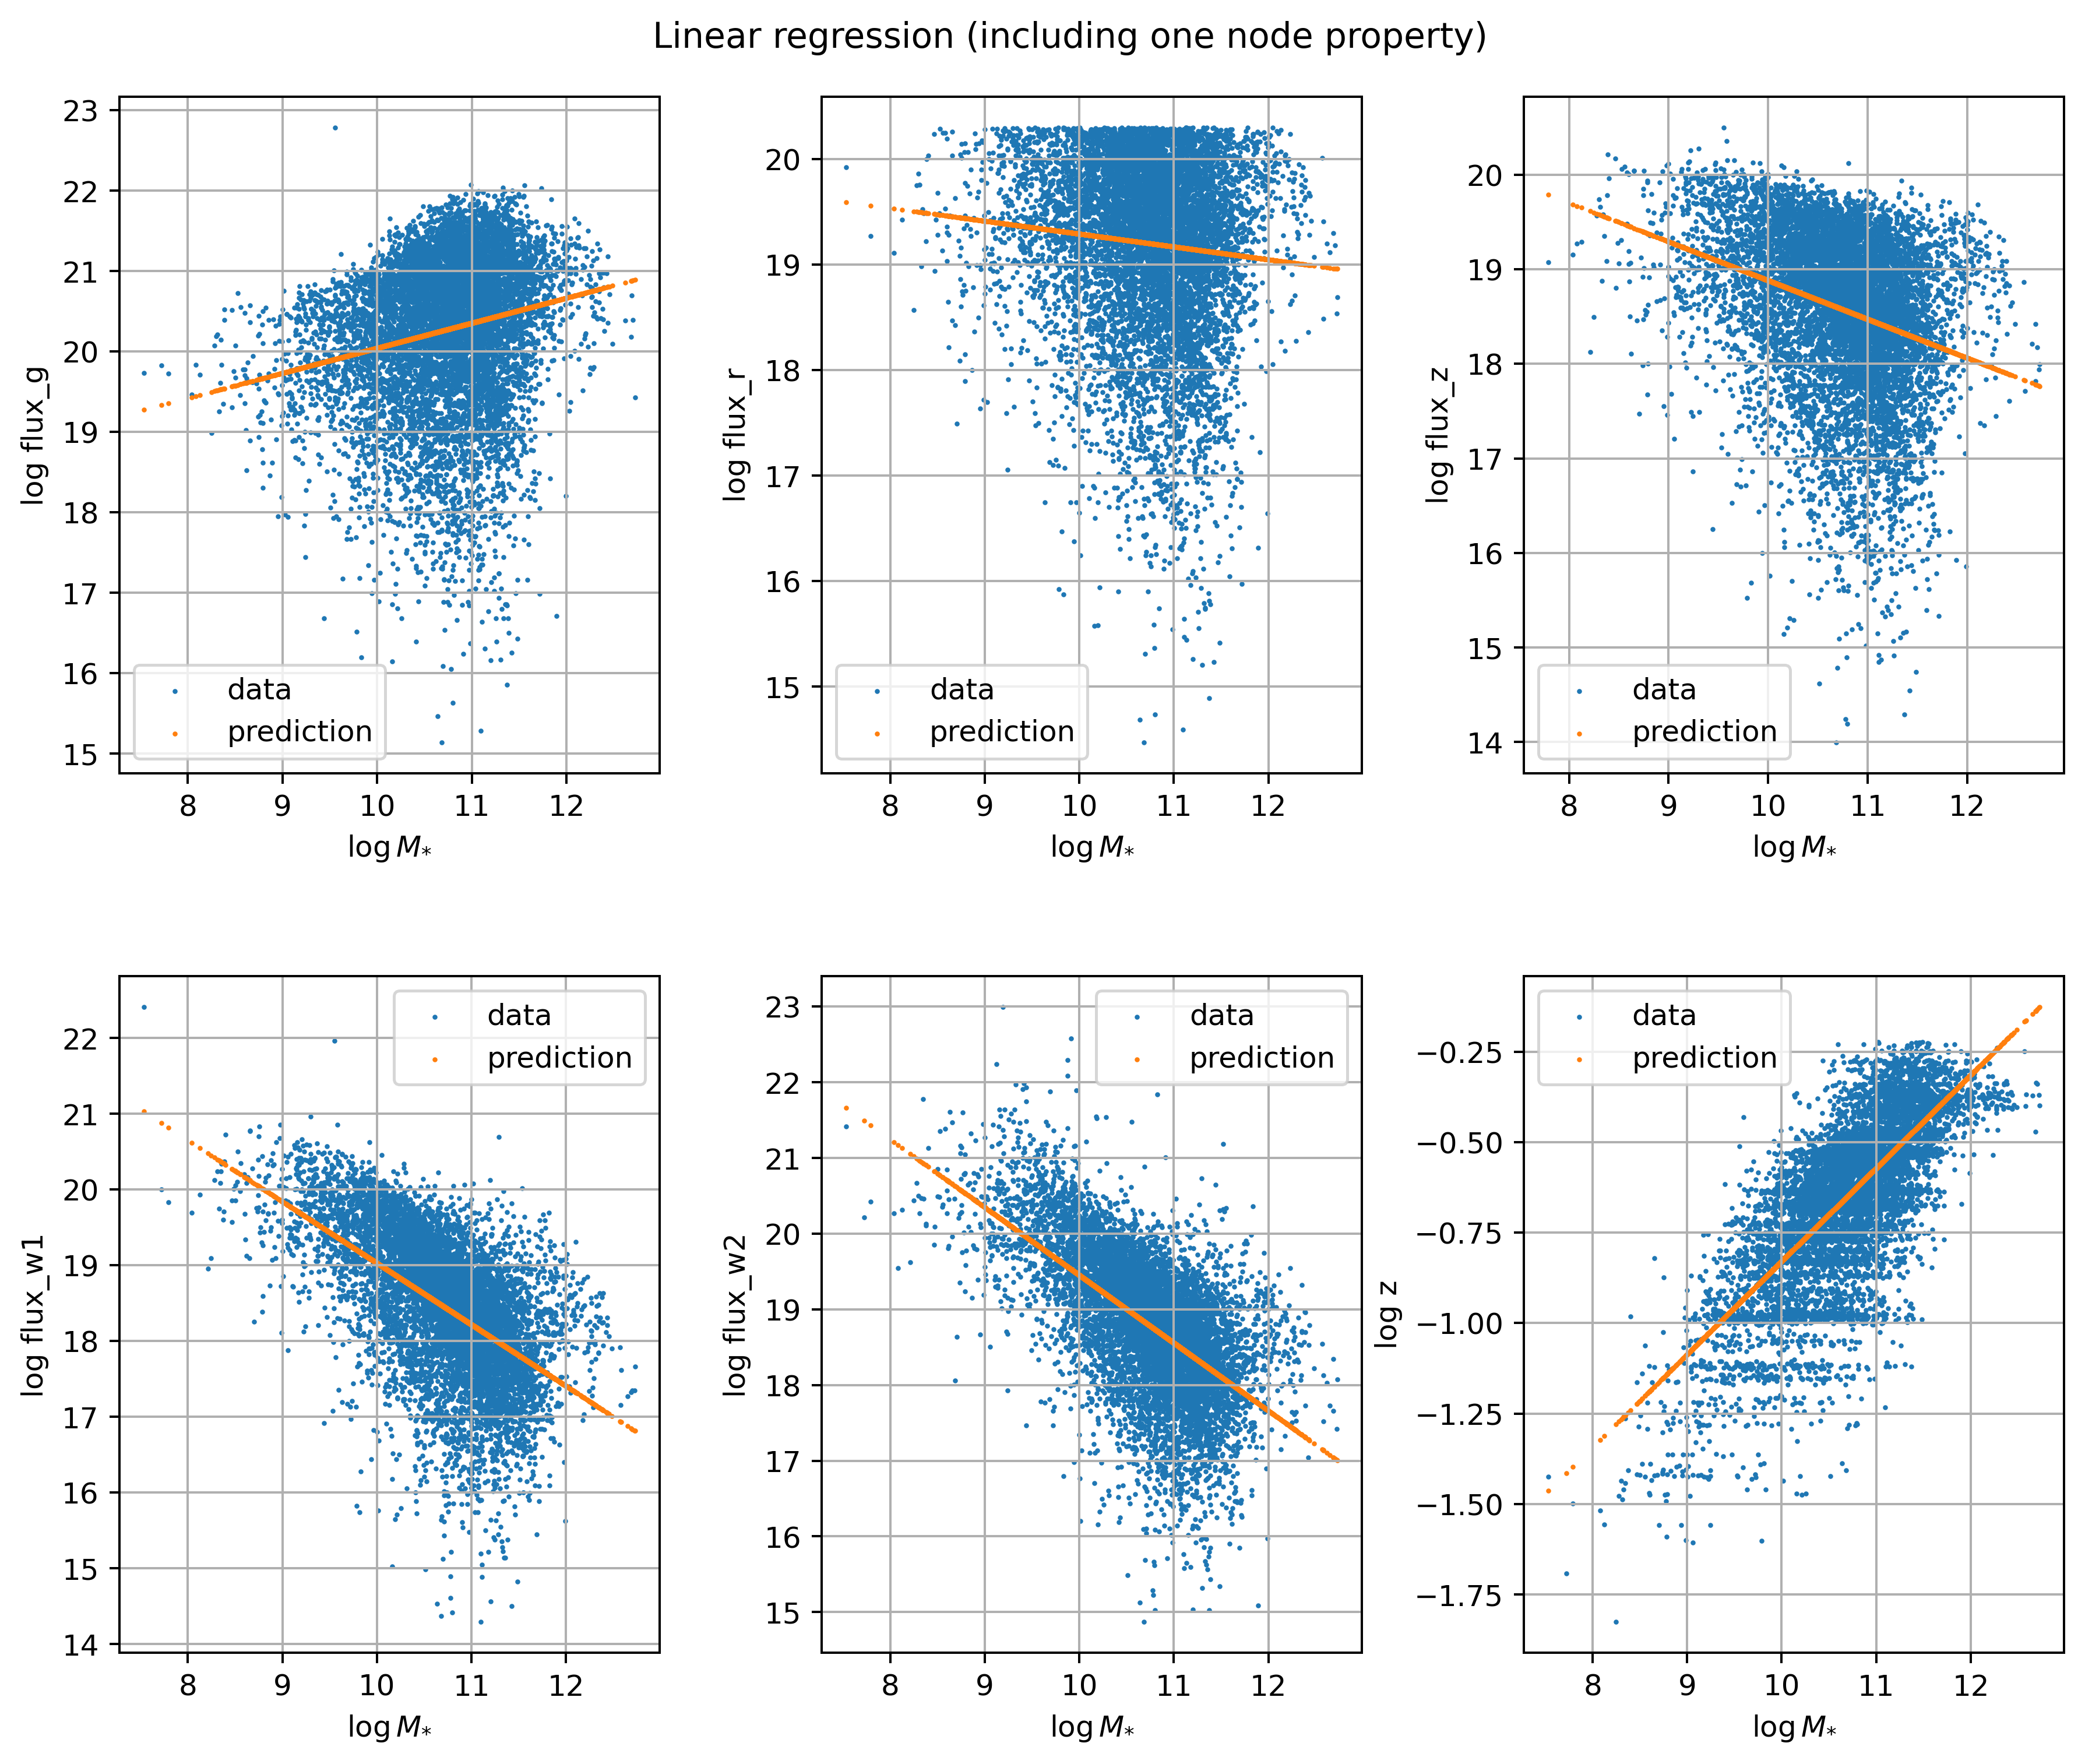

In [9]:
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)

x_pred, y_pred = np.array(x_pred), np.array(y_pred)
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].scatter(x_pred[i*ncols+j], y_pred[i*ncols+j][0], s=0.5, label='data')
        axes[i, j].scatter(x_pred[i*ncols+j], y_pred[i*ncols+j][1], s=0.5, label='prediction')
        axes[i, j].legend()
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].set_ylabel(f'log {props[i*ncols+j]}')
        axes[i, j].grid()

plt.suptitle('Linear regression (including one node property)', y=1.02)
plt.show()

Predictions in a different rosette

In [10]:
x_pred, y_pred = [], []

for p in range(len(props)):
    X, y, ms = [], [], []

    for r in rosettes[1:2]: #* Rosette 6
        nodes, _, _ = graph_r(r)
        y.extend(np.array([n[p+2] for n in nodes])) #input flux-z
        X.extend(np.array([n[1] for n in nodes]).reshape(-1, 1)) #mass

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.9) #*training

    x_pred.append([t[0] for t in X_test])
    y_pred.append((y_test,model.predict(X_test)))

    ms.append((model.score(X_test, y_test),mean_squared_error(y_test, model.predict(X_test))))
    print(f'R^2, {props[p]}: {ms[-1][0]}, mse: {ms[-1][1]}')

R^2, flux_g: -449.64286596366134, mse: 438.97639292570824
R^2, flux_r: -523.1407715357234, mse: 395.5272227576427
R^2, flux_z: -482.92267883464217, mse: 371.1495555300346
R^2, flux_w1: -434.6119595359975, mse: 366.24633317603985
R^2, flux_w2: -432.4614592179547, mse: 380.1952083760465
R^2, z: 0.5643789736607459, mse: 0.025970771769583935


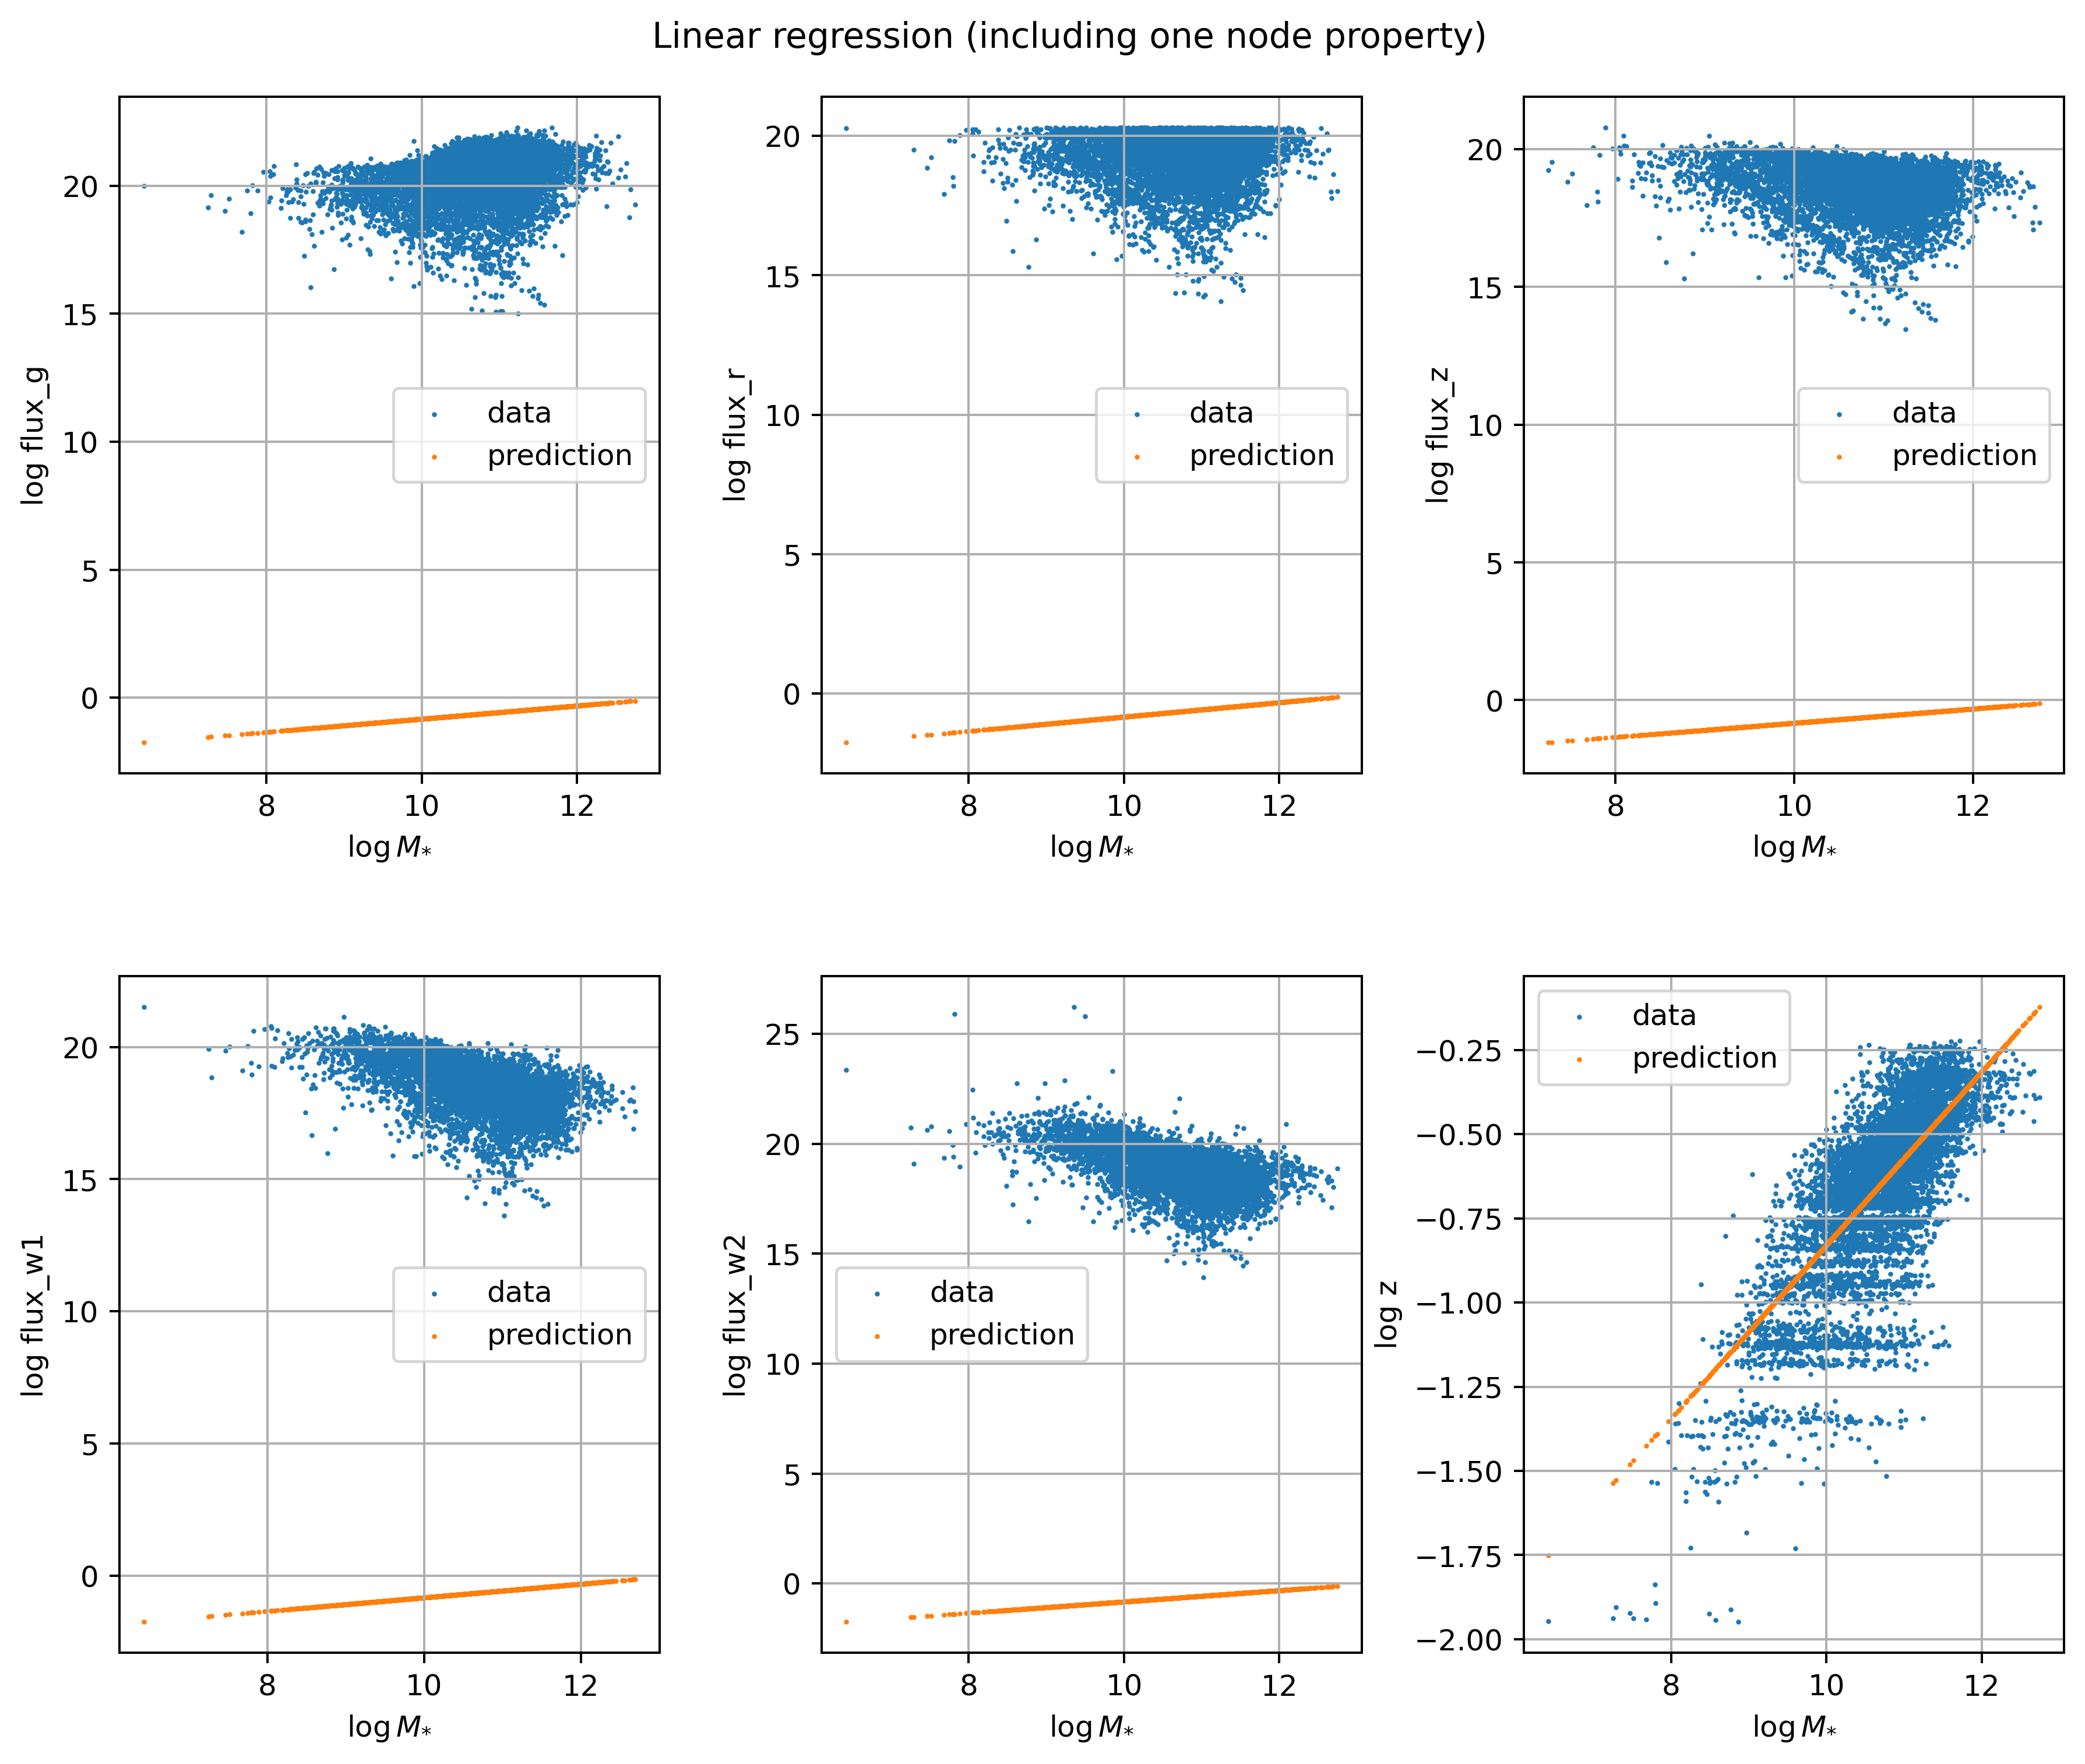

In [11]:
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)

x_pred, y_pred = np.array(x_pred), np.array(y_pred)
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].scatter(x_pred[i*ncols+j], y_pred[i*ncols+j][0], s=0.5, label='data')
        axes[i, j].scatter(x_pred[i*ncols+j], y_pred[i*ncols+j][1], s=0.5, label='prediction')
        axes[i, j].legend()
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].set_ylabel(f'log {props[i*ncols+j]}')
        axes[i, j].grid()

plt.suptitle('Linear regression (including one node property)', y=1.02)
plt.show()

#### Including **all** [flux_g, flux_r, flux_z, flux_w1, flux_w2, z]

In [12]:
model = LinearRegression()

X, y = [], []
for r in rosettes[:1]: #Rosette 3
    nodes, _, _ = graph_r(r)
    X.extend([[n[2],n[3],n[4],n[5],n[6],n[7]] for n in nodes])
    y.extend([n[1] for n in nodes])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8)
model.fit(X_train, y_train)
print(f'R^2: {model.score(X_test, y_test)}')
print(f'mse: {mean_squared_error(y_test, model.predict(X_test))}')

R^2: 0.9066120675652698
mse: 0.03527813802608907


Predictions in the same rosette

In [13]:
y_pred = model.predict(X_test)
print(f'R^2: {model.score(X_test, y_pred)}')
print(f'mse: {mean_squared_error(y_test, y_pred)}')

R^2: 1.0
mse: 0.03527813802608907


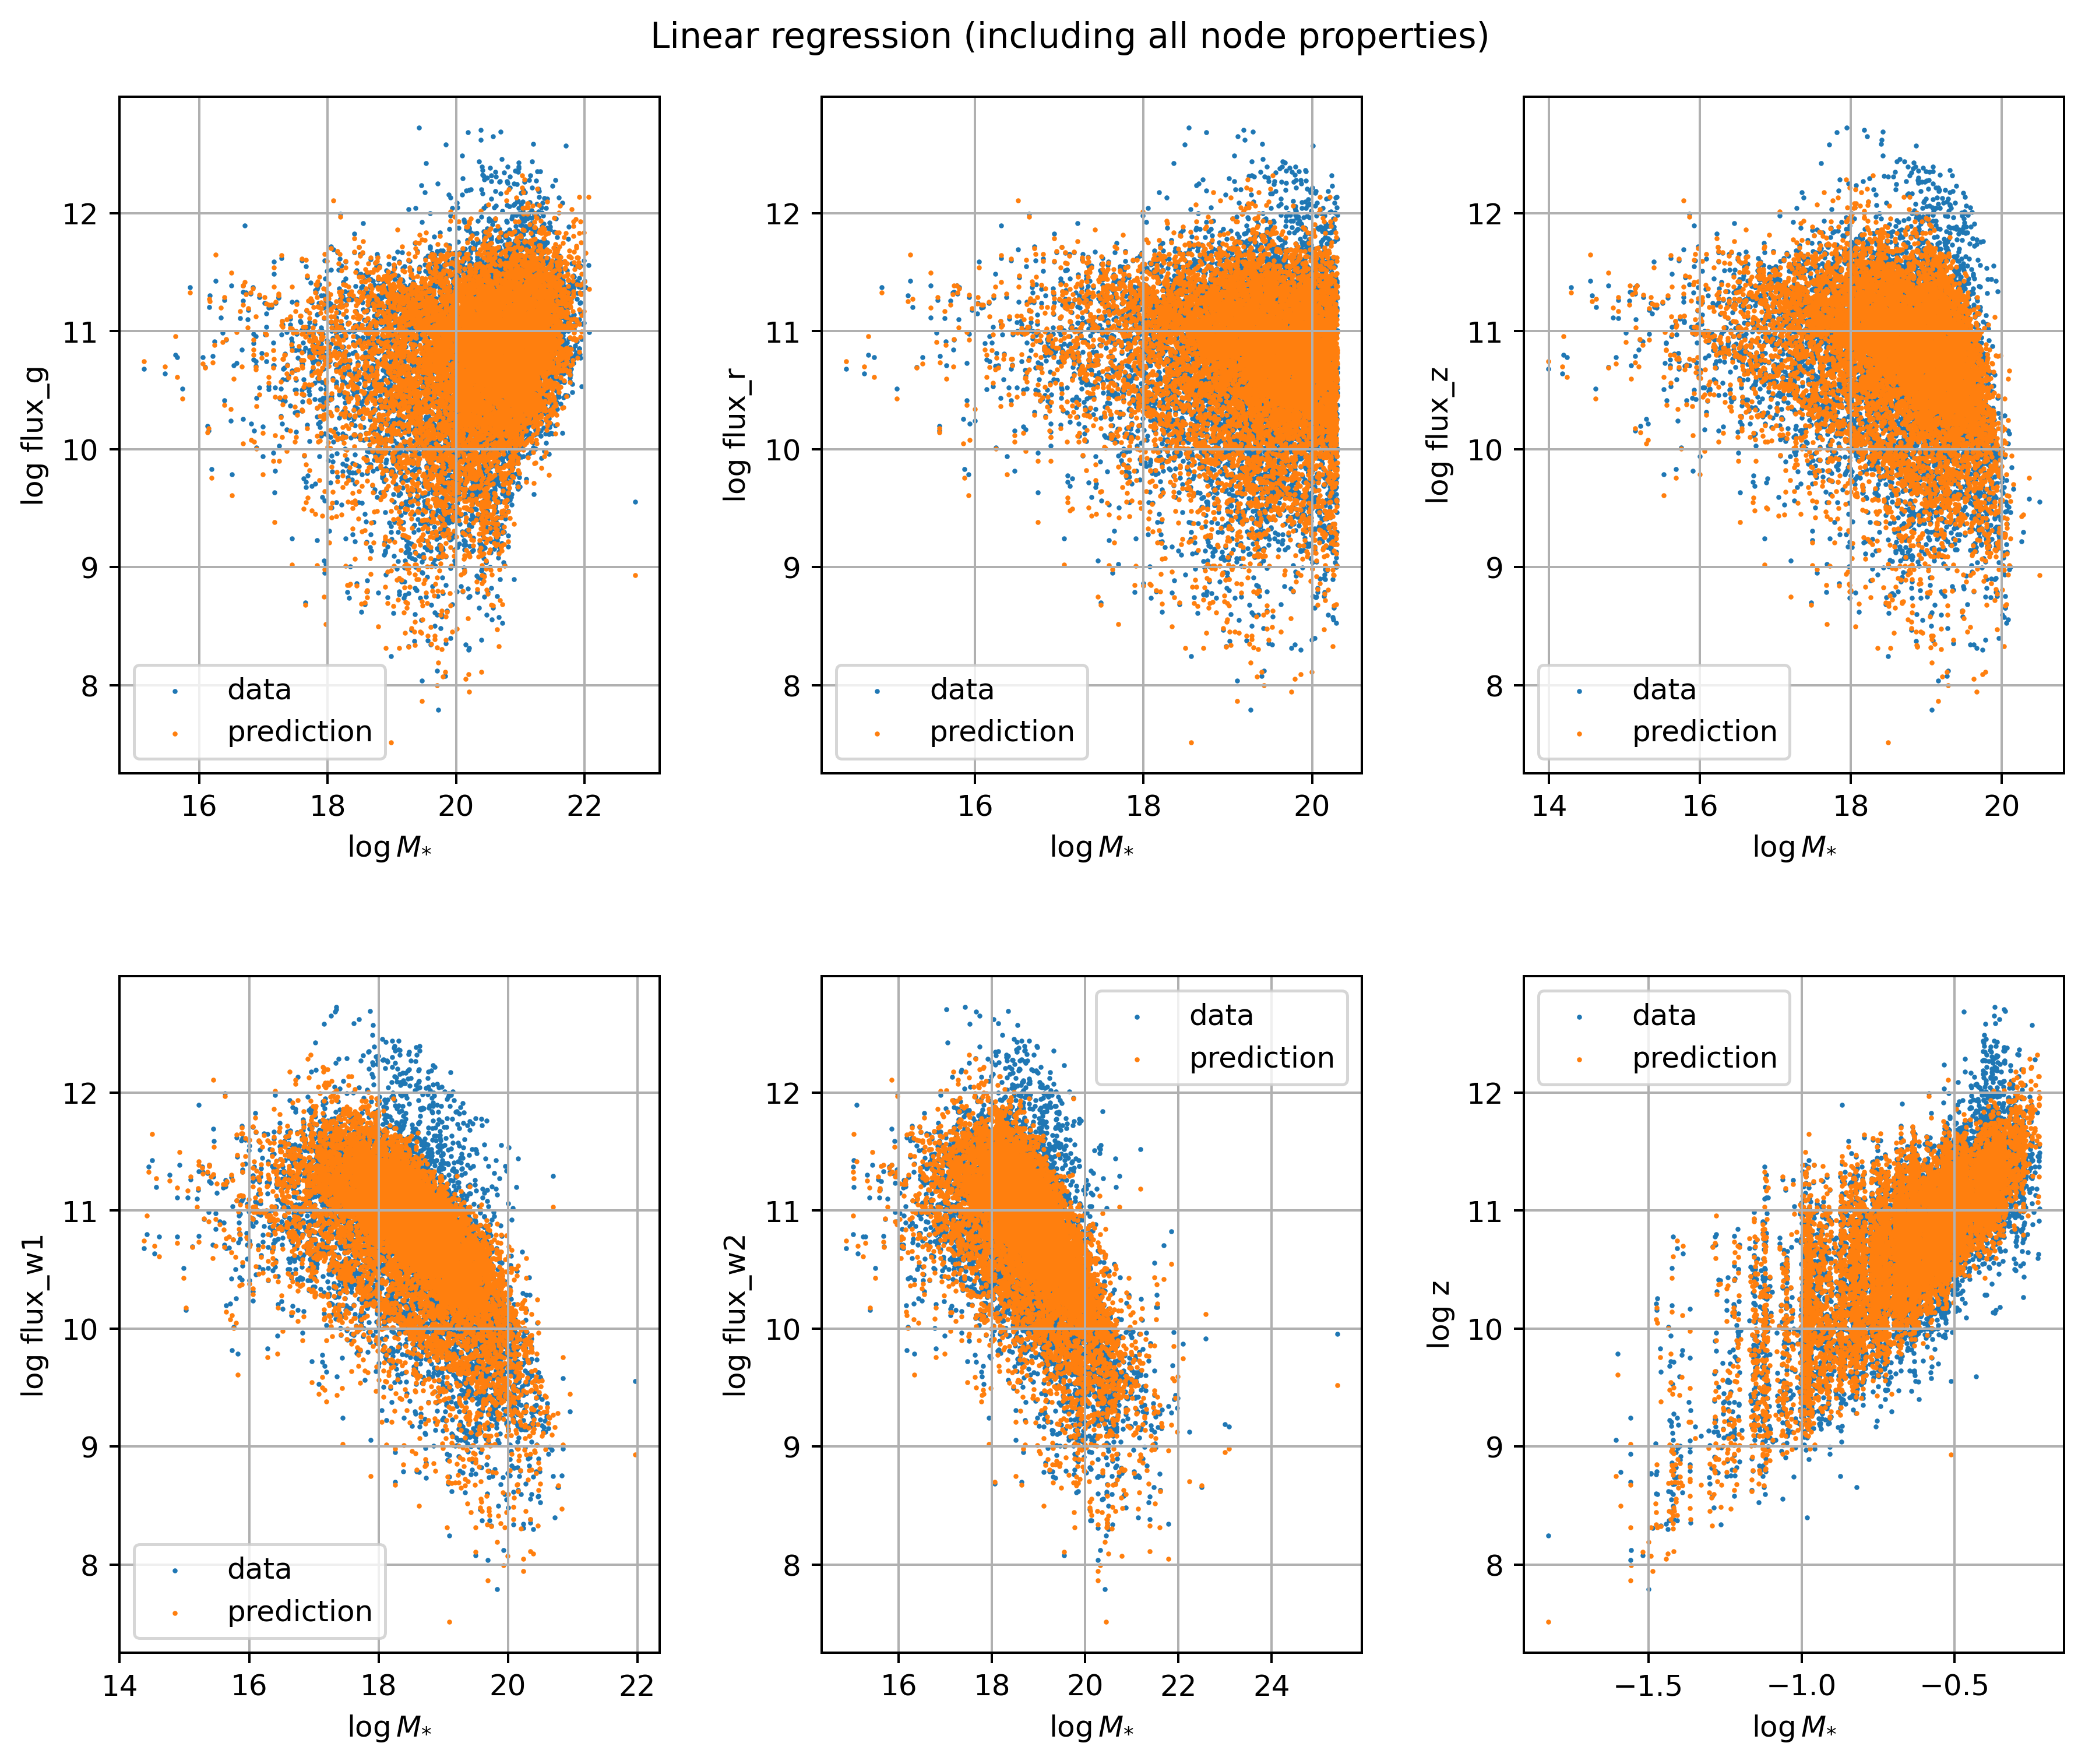

In [14]:
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)

X_test, y_test, y_pred = np.array(X_test), np.array(y_test), np.array(y_pred)

for i in range(nrows):
    for j in range(ncols):
        prop_index = i * ncols + j
        prop_name = props[prop_index]
        axes[i, j].scatter(X_test[:, prop_index], y_test, s=0.5, label='data')  # Datos reales
        axes[i, j].scatter(X_test[:, prop_index], y_pred, s=0.5, label='prediction')  # Predicciones
        axes[i, j].legend()
        axes[i, j].set_ylabel(f'log {prop_name}')
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].grid()

plt.suptitle('Linear regression (including all node properties)', y=1.02)
plt.show()

Predictions in a different rosette

In [15]:
X, y = [], []
for r in rosettes[1:2]: #rosette 6
    nodes, _, _ = graph_r(r)
    X.extend([[n[2],n[3],n[4],n[5],n[6],n[7]] for n in nodes])
    y.extend([n[1] for n in nodes])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8)
y_pred = model.predict(X_test)
print(f'R^2: {model.score(X_test, y_test)}')
print(f'mse: {mean_squared_error(y_test, y_pred)}')

R^2: 0.9132977946100392
mse: 0.03766675515944806


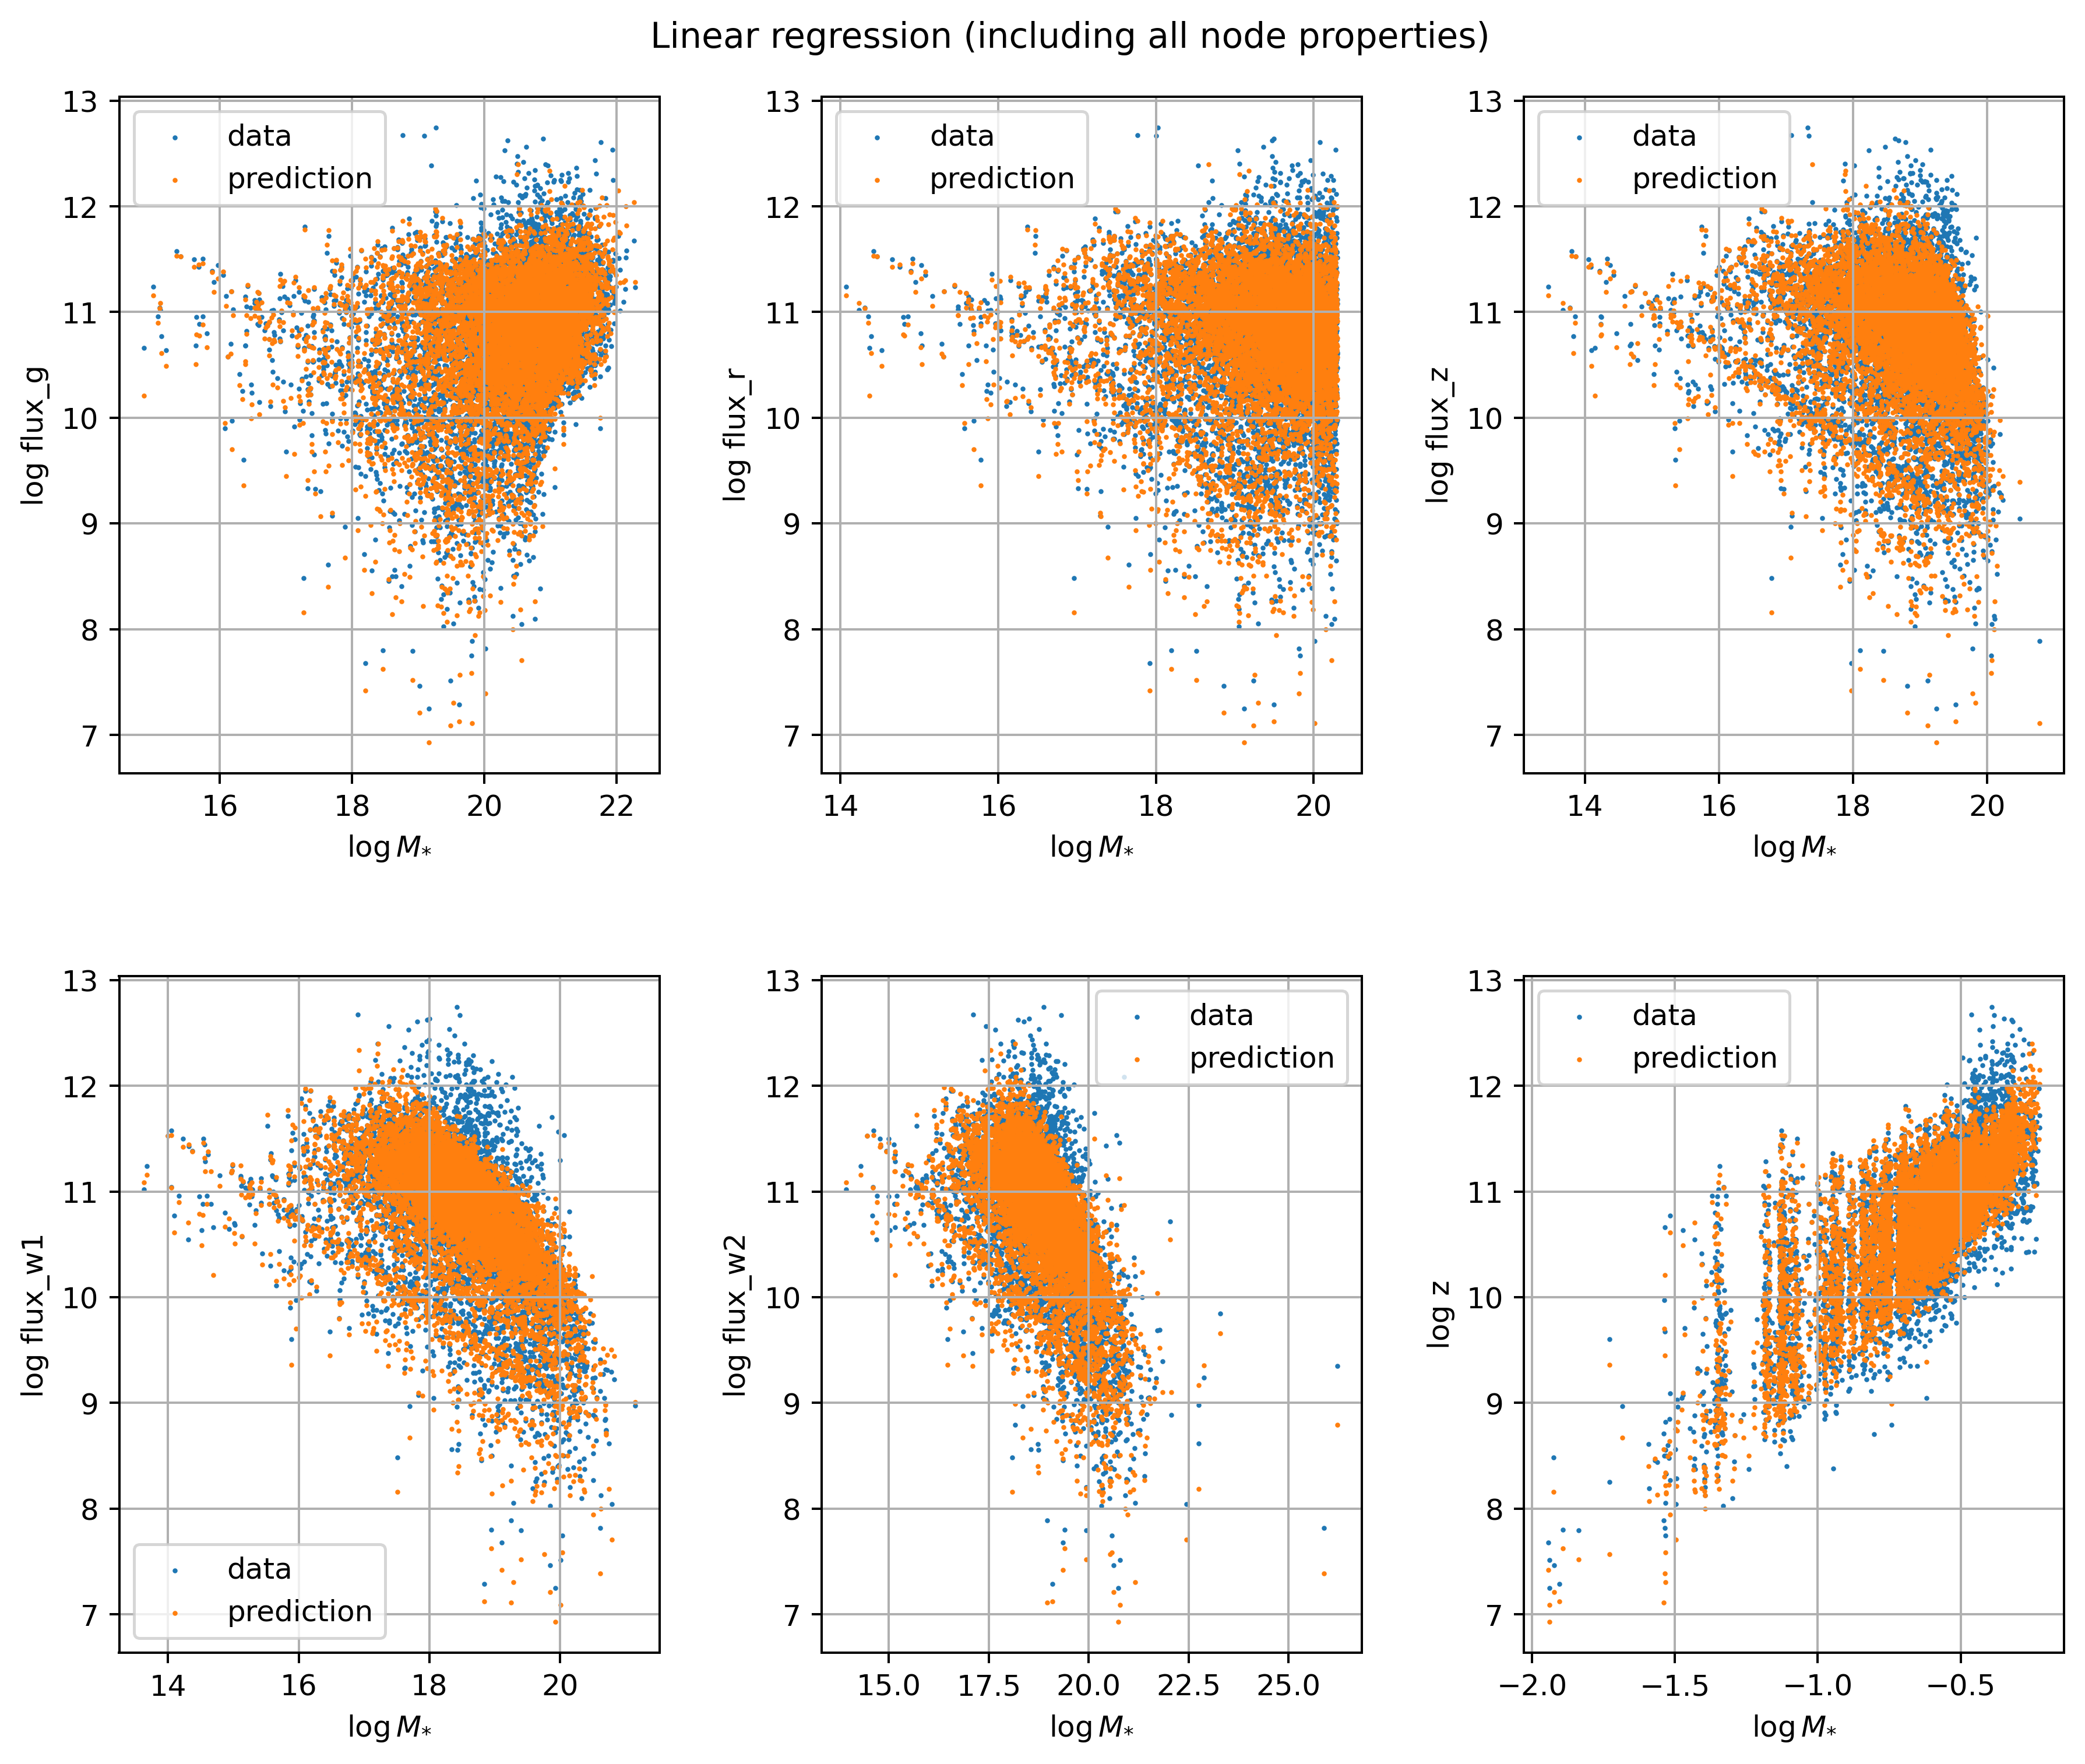

In [16]:
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)

X_test, y_test, y_pred = np.array(X_test), np.array(y_test), np.array(y_pred)

for i in range(nrows):
    for j in range(ncols):
        prop_index = i * ncols + j
        prop_name = props[prop_index]
        axes[i, j].scatter(X_test[:, prop_index], y_test, s=0.5, label='data')  # Datos reales
        axes[i, j].scatter(X_test[:, prop_index], y_pred, s=0.5, label='prediction')  # Predicciones
        axes[i, j].legend()
        axes[i, j].set_ylabel(f'log {prop_name}')
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].grid()

plt.suptitle('Linear regression (including all node properties)', y=1.02)
plt.show()

### Random Forest

In [39]:
nodes, _, _ = graph_r(rosettes[0])
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
regressor = RandomForestRegressor(n_estimators=100, random_state=0)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.03571028973132311


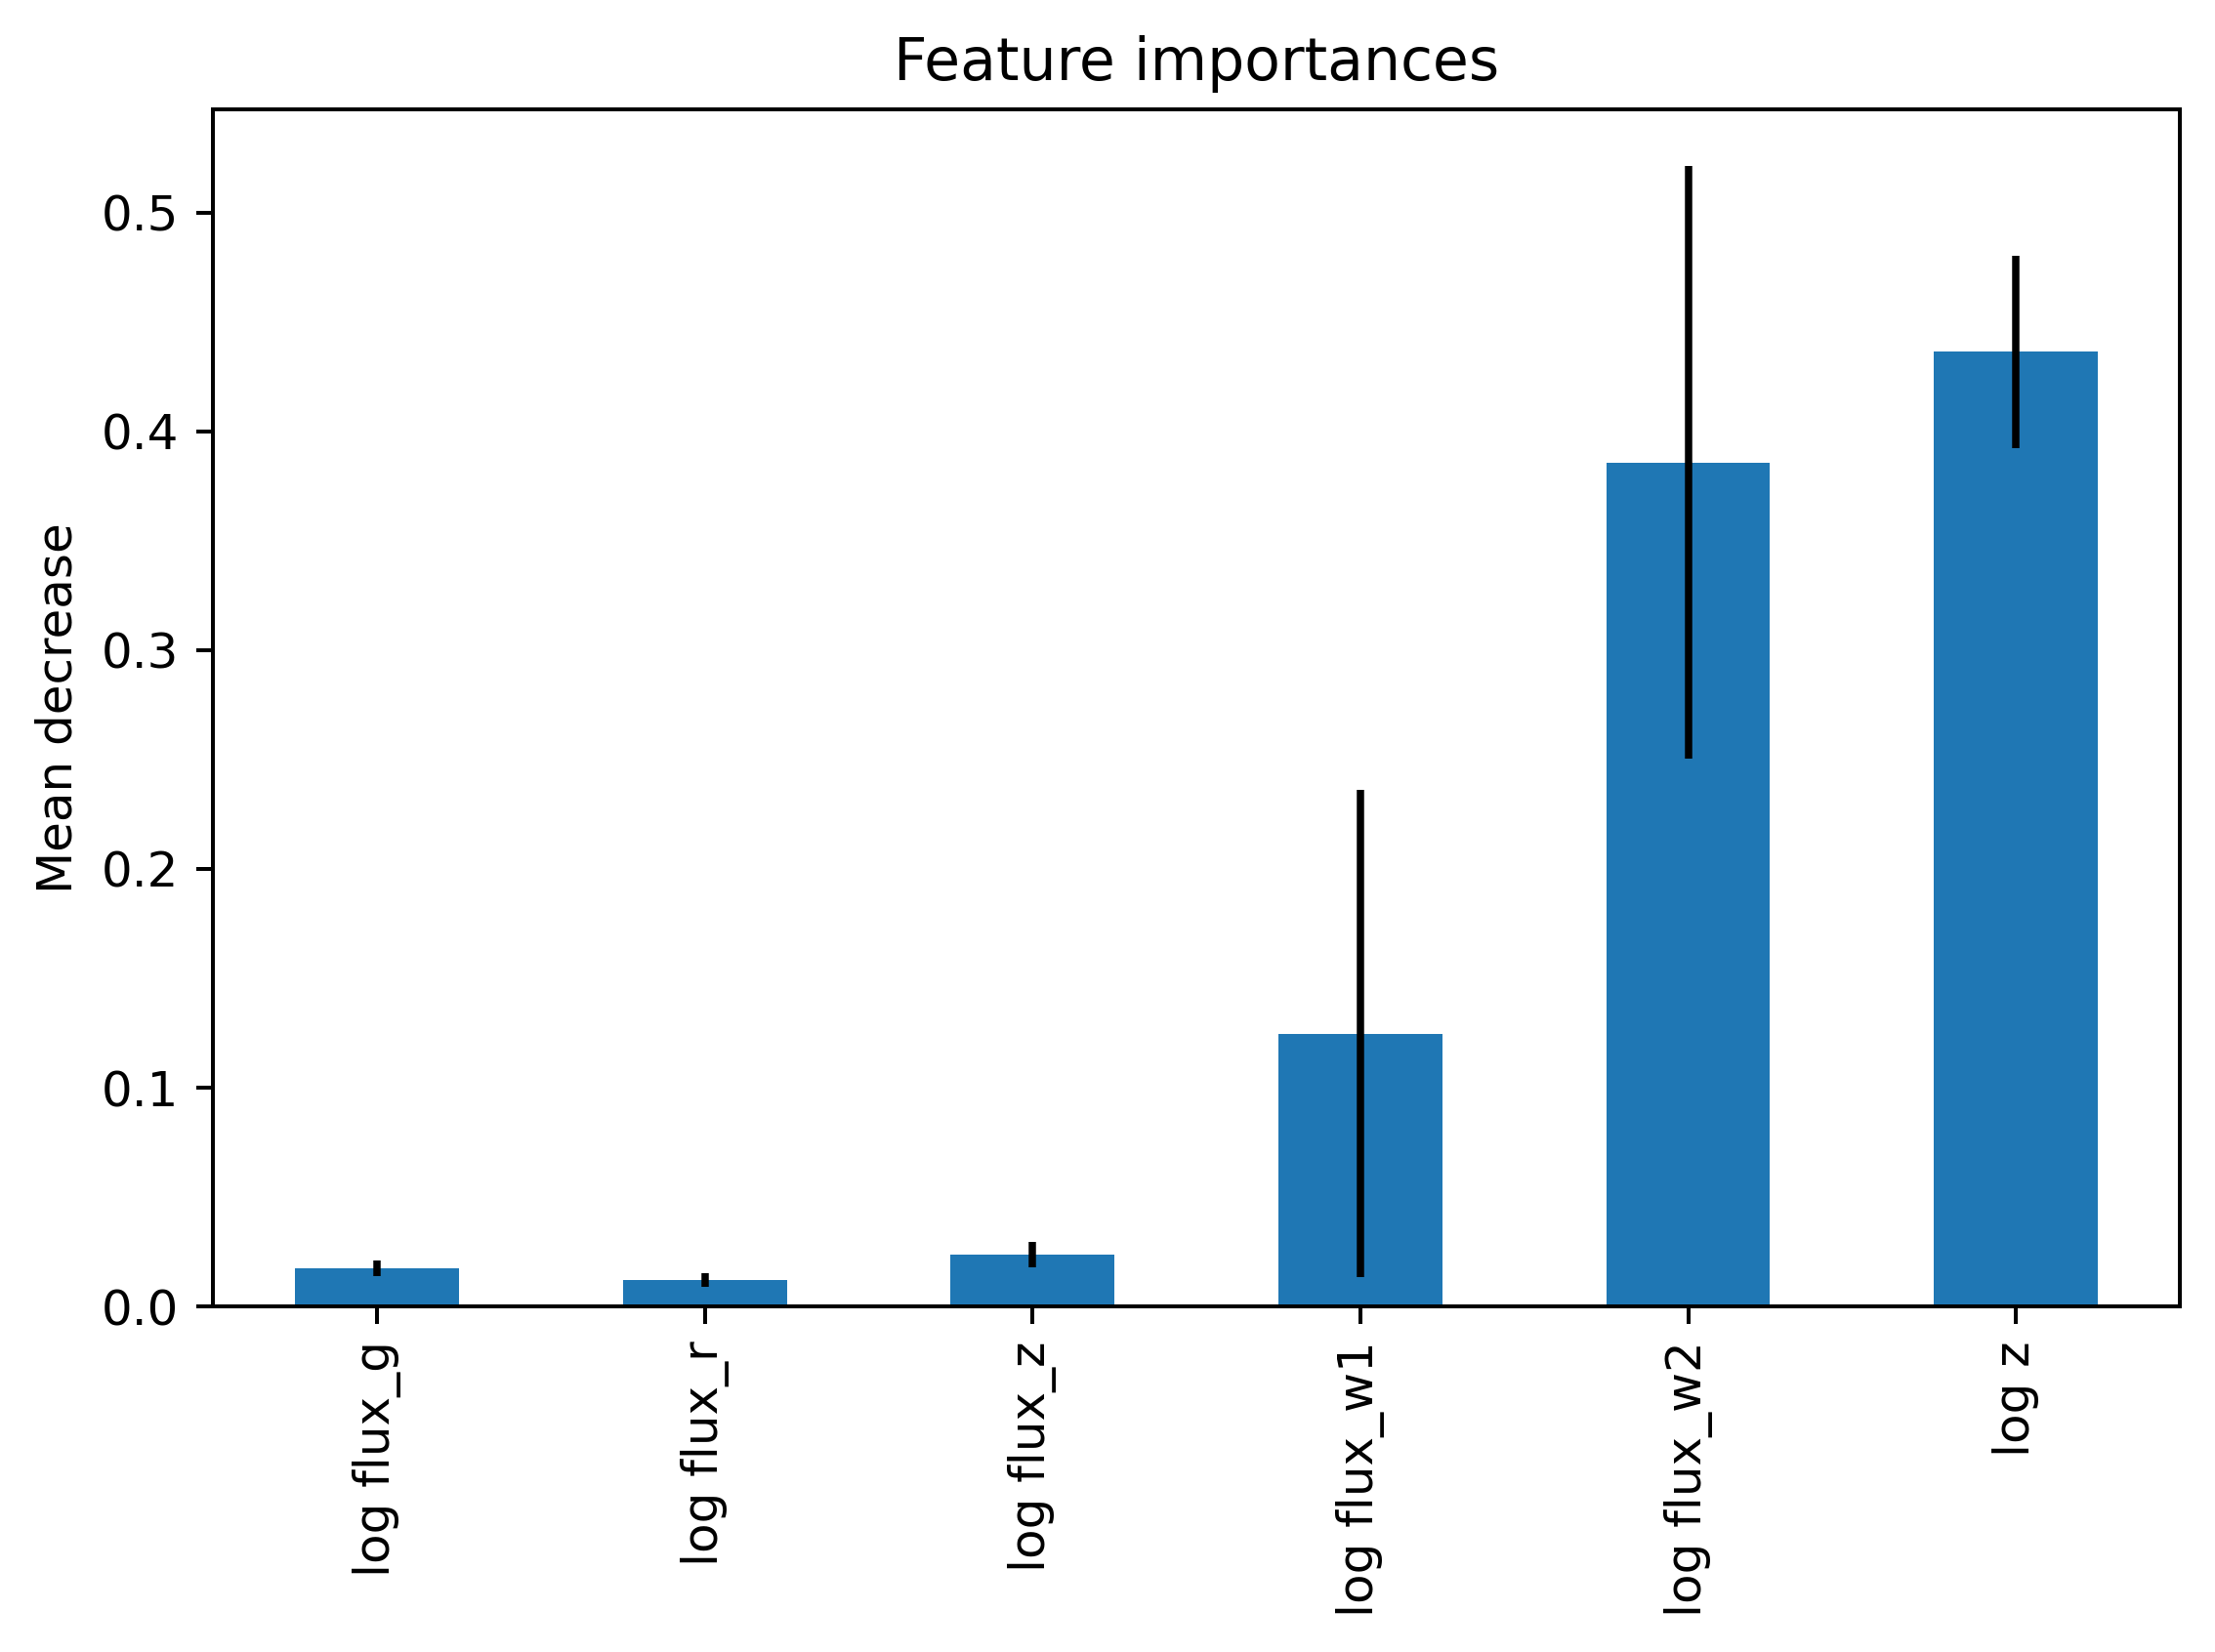

In [35]:
props = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

feature_names = [f"log {i}" for i in props]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease")
fig.tight_layout()

Adding a random column

In [40]:
nodes, _, _ = graph_r(rosettes[0])
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
regressor_rdm = RandomForestRegressor(n_estimators=100, random_state=0)

random_column = np.random.rand(len(y_train)) #random column
X_train_extended = np.column_stack((X_train, random_column))
regressor_rdm.fit(X_train_extended, y_train)

X_test_extended = np.column_stack((X_test, np.random.rand(len(y_test))))
y_pred_extended = regressor_rdm.predict(X_test_extended)

mse = mean_squared_error(y_test, y_pred_extended)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.036034424872100505


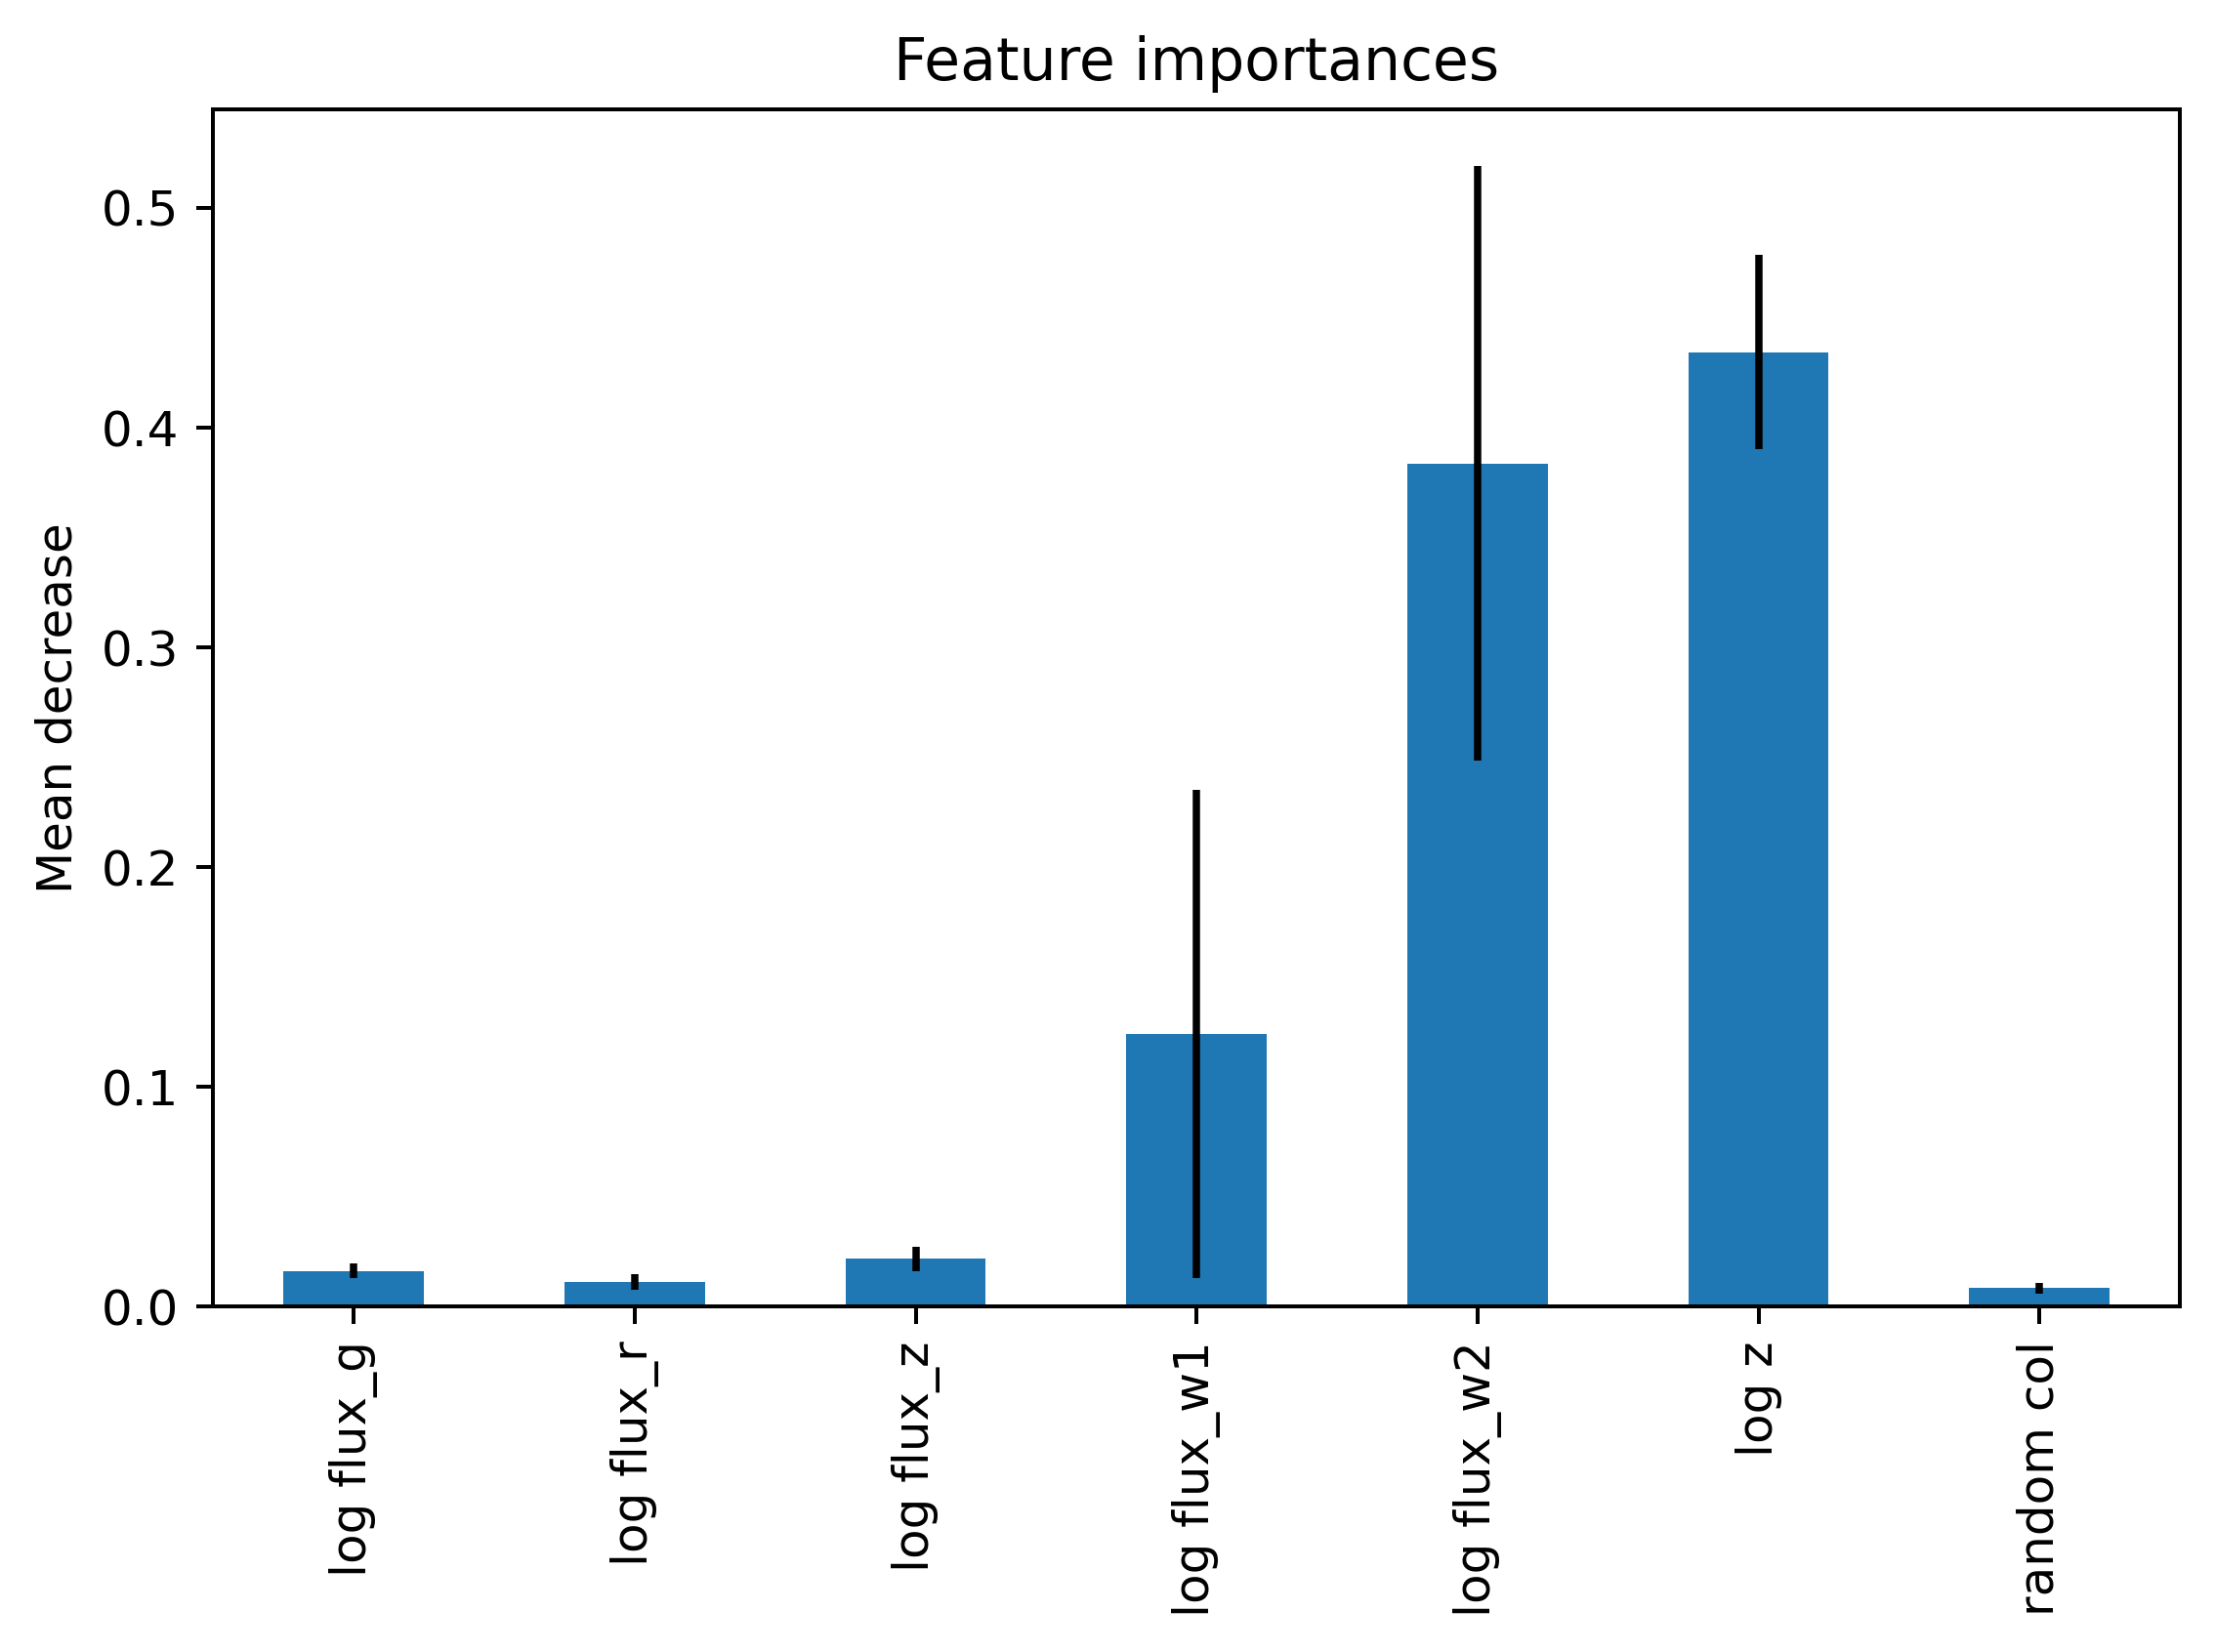

In [41]:
importances = regressor_rdm.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor_rdm.estimators_], axis=0)

props = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z', 'random col']
feature_names = [f"log {i}" for i in props[:-1]]
feature_names.append(props[-1])
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease")
fig.tight_layout()

Predictions in a different rosette

In [42]:
nodes, _, _ = graph_r(rosettes[1])
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]
_, X_test, _, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.04203419278273974


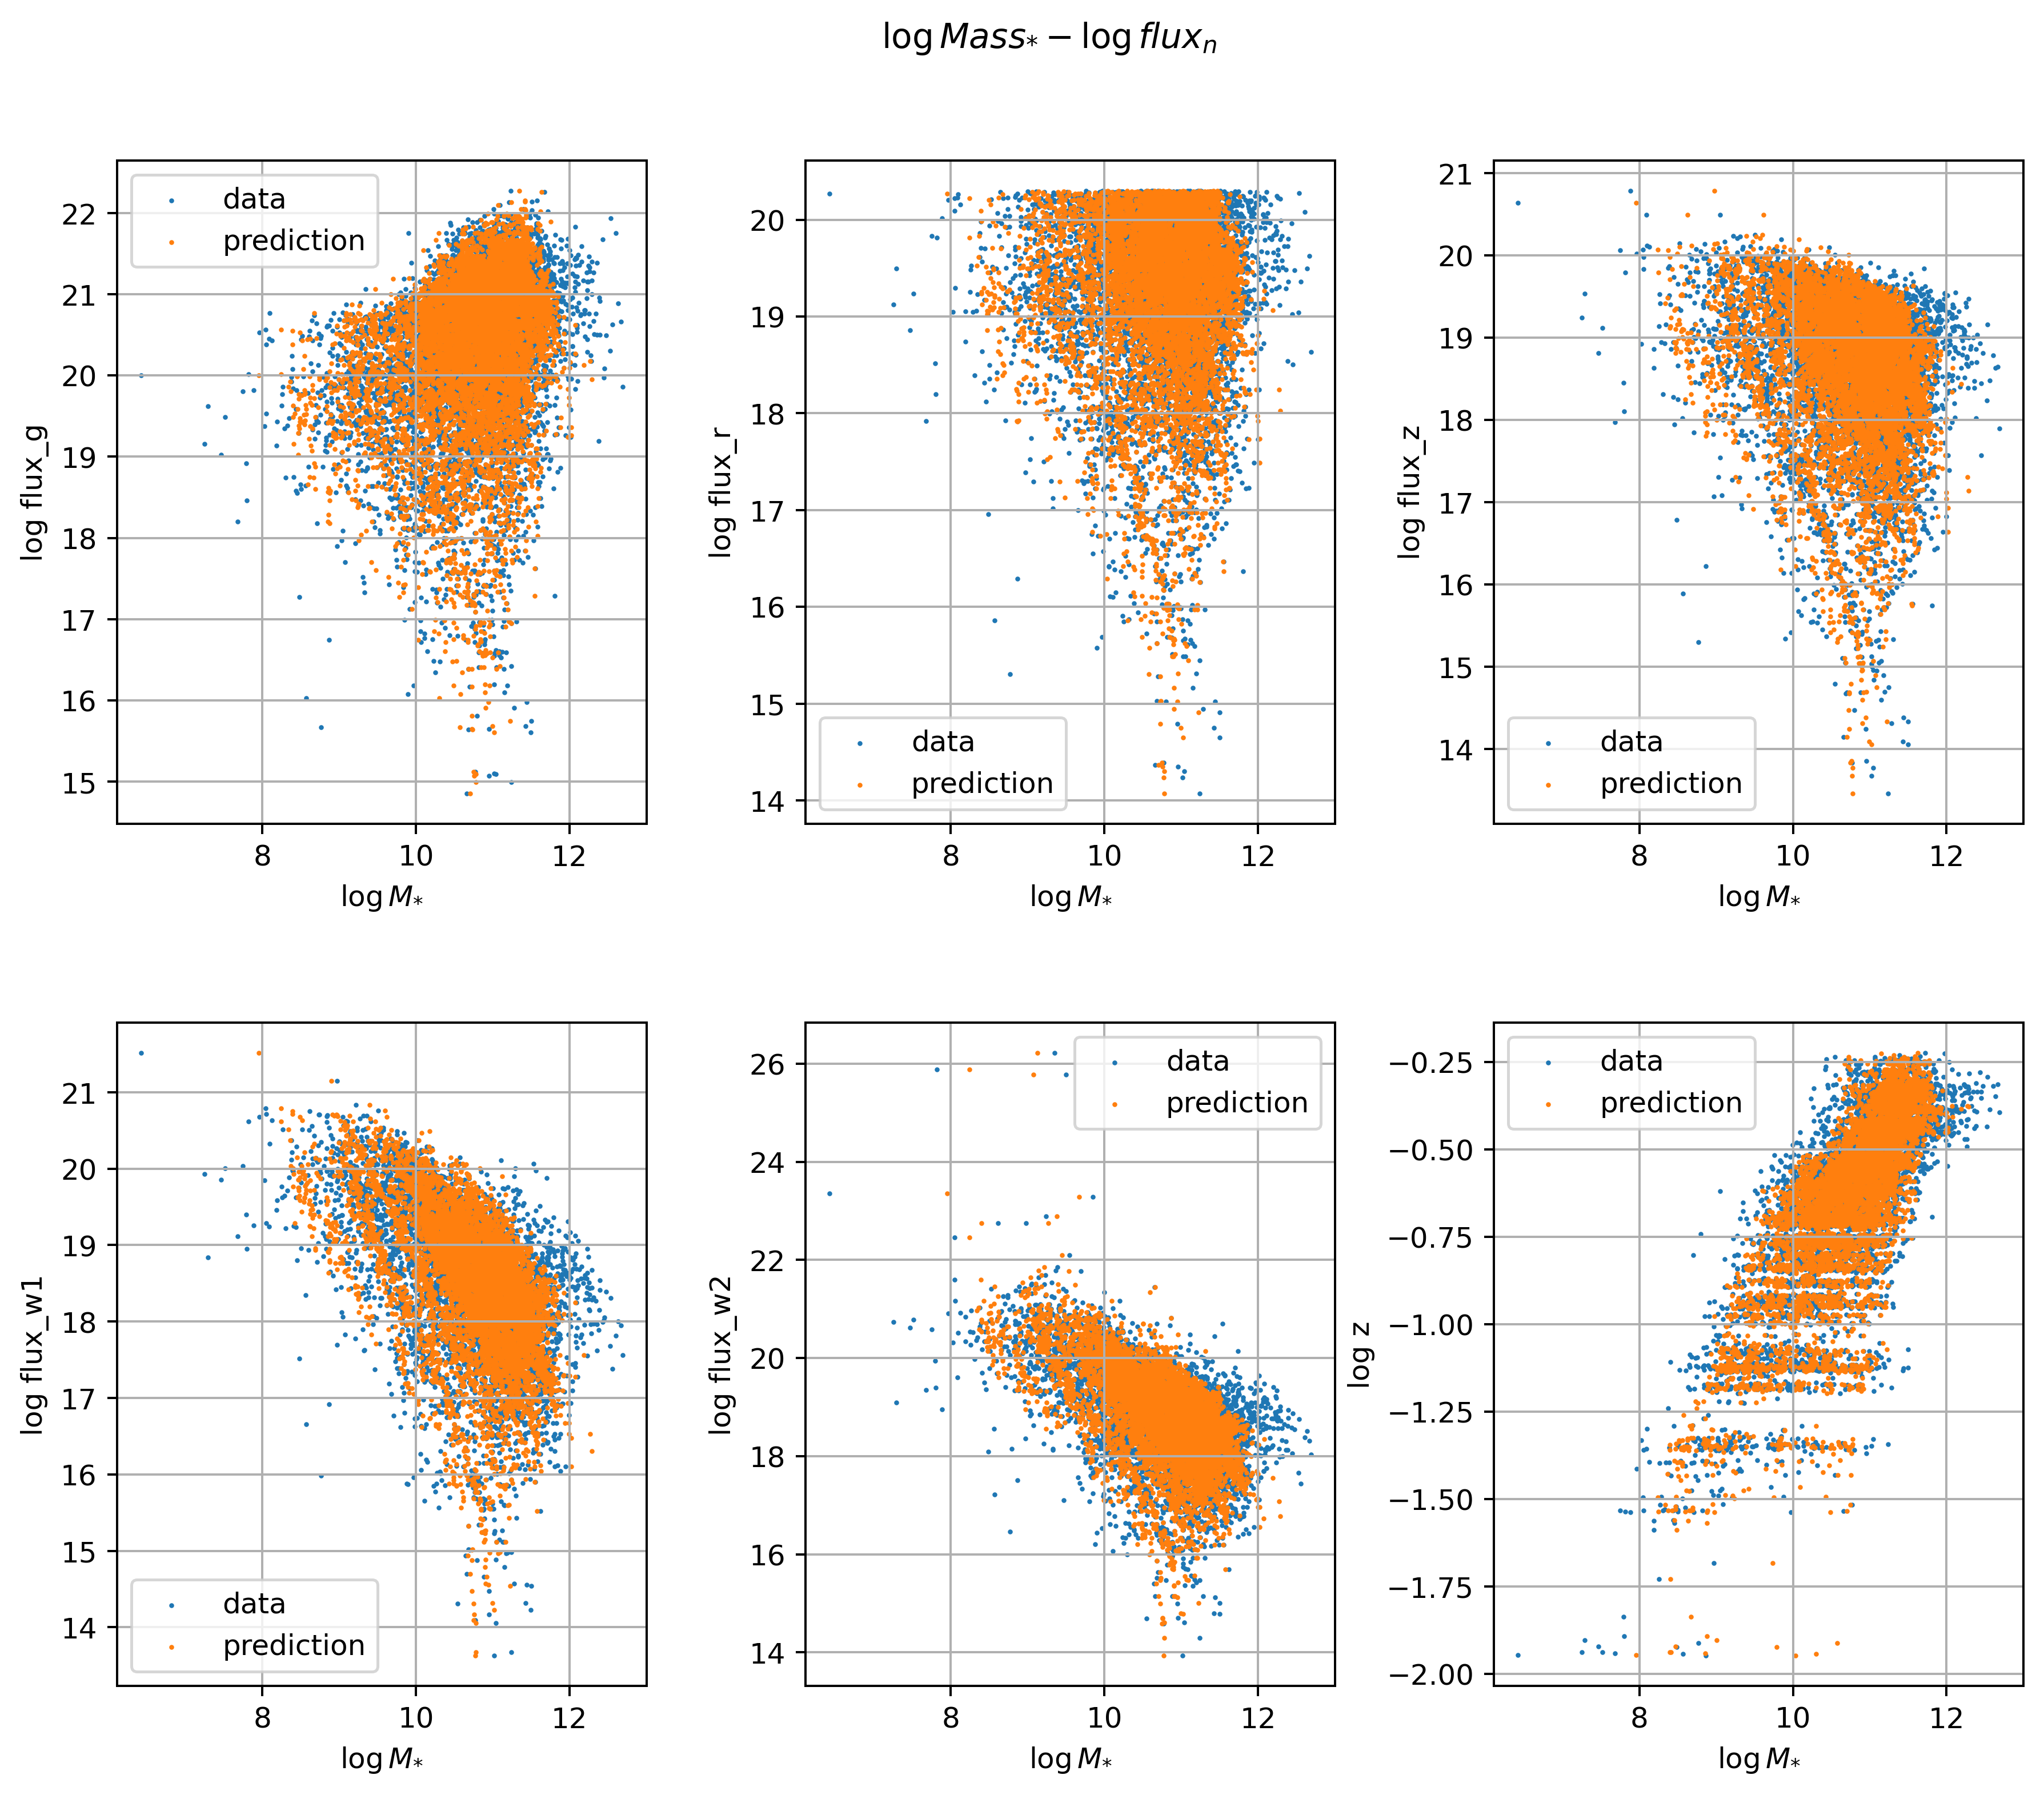

In [44]:
nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
plt.tight_layout()
plt.suptitle(r'$\log{Mass_{*}} - \log{flux_{n}}$', y=1.06)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

X_test, y_test, y_pred = np.array(X_test), np.array(y_test), np.array(y_pred)

labels = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']

for i in range(2):
    for j in range(3):
        prop_index = i * 3 + j
        axes[i, j].scatter(y_test, X_test[:, prop_index], s=0.5, label='data')
        axes[i, j].scatter(y_pred, X_test[:, prop_index], s=0.5, label='prediction')
        axes[i, j].legend()
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].set_ylabel(f'log {labels[prop_index]}')
        axes[i, j].grid()

plt.show()